Welcome to our Big Data and Cloud Computing project.
This work was made by:
*   Rafael Conceição
*   Alexandre Marques
*   Nuno Moreira

*FCUP* - CDLE - 23/24


# Introduction and objectives:

In this work we explore the MIMIC-III dataset, which is a large and free dataset containing data about over 40000 patients in different hospital/ICU stays.

The goal of our work is extracting meaningful data from this dataset, with the objective of predicting the lenght of stay of our patient, given specific information

We decided to use BigQuery by Google, which is is a highly scalable, serverless data warehouse designed for fast SQL queries and large-scale data analysis.

BigQuery's integration with various data tools makes it an ideal choice for preprocessing and querying the MIMIC-III dataset, allowing us to extract and transform data quickly and effectively.

We also decided to do more than one approach to this problem, in order to compare the different data processing and seeing the respective results.

In the last two we decide to use dask since we were managing more data and we wanted fast processing

Dask allows for parallel and distributed computations, it is particularly suitable for this project due to its capability to handle large datasets that do not fit into memory, making it an excellent choice for processing the vast amount of data in the MIMIC-III dataset.

Let's get started.

##Necessary imports

In [ ]:
!pip install dask_ml

In [ ]:
!pip install dask_bigquery

##Create the big query client

In [ ]:
from google.cloud import bigquery
import pandas as pd

In [ ]:
# Initialize a BigQuery client
client = bigquery.Client()


## Check the columns of the datasets

In [ ]:
# Define the query
query = """
SELECT *
FROM `DATASET.ADMISSIONS`
LIMIT 1000
"""

# Execute the query and convert the results to a pandas DataFrame
df = client.query(query).to_dataframe()

# Display the DataFrame
df.head()


ROW_ID  SUBJECT_ID  HADM_ID                 ADMITTIME  \
0    8902        7275   136809 2139-08-28 12:35:00+00:00   
1   21467       17575   187131 2124-10-21 08:32:00+00:00   
2   30863       25251   142346 2167-01-23 16:23:00+00:00   
3   39212       32339   181355 2110-07-29 23:56:00+00:00   
4   37441       30746   155603 2131-08-22 23:07:00+00:00   

                  DISCHTIME DEATHTIME ADMISSION_TYPE    ADMISSION_LOCATION  \
0 2139-09-01 16:32:00+00:00       NaT      EMERGENCY  EMERGENCY ROOM ADMIT   
1 2124-11-01 11:14:00+00:00       NaT      EMERGENCY  EMERGENCY ROOM ADMIT   
2 2167-02-06 13:53:00+00:00       NaT      EMERGENCY  EMERGENCY ROOM ADMIT   
3 2110-08-04 15:10:00+00:00       NaT      EMERGENCY  EMERGENCY ROOM ADMIT   
4 2131-08-28 13:10:00+00:00       NaT      EMERGENCY  EMERGENCY ROOM ADMIT   

  DISCHARGE_LOCATION   INSURANCE LANGUAGE      RELIGION MARITAL_STATUS  \
0                ICF    Medicare     ENGL  EPISCOPALIAN       DIVORCED   
1                ICF  Government     None         OTHER         SINGLE   
2                ICF    Medicare     None  EPISCOPALIAN       DIVORCED   
3                ICF    Medicare     ENGL        JEWISH        MARRIED   
4                ICF    Medicare     ENGL        JEWISH       DIVORCED   

                ETHNICITY                 EDREGTIME                 EDOUTTIME  \
0                   WHITE 2139-08-28 10:38:00+00:00 2139-08-28 14:30:00+00:00   
1  BLACK/AFRICAN AMERICAN 2124-10-21 05:04:00+00:00 2124-10-21 09:52:00+00:00   
2                   WHITE 2167-01-23 12:54:00+00:00 2167-01-23 18:00:00+00:00   
3                   WHITE 2110-07-29 20:17:00+00:00 2110-07-30 01:24:00+00:00   
4                   WHITE 2131-08-22 14:15:00+00:00 2131-08-23 01:20:00+00:00   

                                     DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
0               ALTERED MENTAL STATUS; DYSPNEA                     0   
1                                   MVA;TRAUMA                     0   
2                          INFECTED RIGHT FOOT                     0   
3  GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY                     0   
4                        ALTERED MENTAL STATUS                     0   

   HAS_CHARTEVENTS_DATA  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [ ]:
# Define the query
query = """
SELECT *
FROM `DATASET.ICUSTAYS`
LIMIT 1000
"""

# Execute the query and convert the results to a pandas DataFrame
df = client.query(query).to_dataframe()

# Display the DataFrame
df.head()

ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID    DBSOURCE FIRST_CAREUNIT  \
0     372         275   129886      219649     carevue            CCU   
1     389         291   113649      256641     carevue            CCU   
2     390         291   125726      275109  metavision            CCU   
3     394         294   152578      222074     carevue            CCU   
4     401         301   160332      288401     carevue            CCU   

  LAST_CAREUNIT  FIRST_WARDID  LAST_WARDID                    INTIME  \
0           CCU             7            7 2170-10-07 11:28:53+00:00   
1           CCU             7            7 2102-04-08 23:05:28+00:00   
2           CCU             7            7 2106-04-17 12:26:17+00:00   
3           CCU             7            7 2118-01-17 21:45:05+00:00   
4           CCU             7            7 2189-11-11 12:12:33+00:00   

                    OUTTIME     LOS  
0 2170-10-14 14:38:07+00:00  7.1314  
1 2102-04-09 11:20:11+00:00  0.5102  
2 2106-04-18 22:05:39+00:00  1.4023  
3 2118-01-20 11:12:45+00:00  2.5609  
4 2189-11-13 22:11:28+00:00  2.4159

In [ ]:
# Define the query
query = """
SELECT *
FROM `DATASET.PATIENTS`
LIMIT 1000
"""

# Execute the query and convert the results to a pandas DataFrame
df = client.query(query).to_dataframe()

# Display the DataFrame
df.head()

ROW_ID  SUBJECT_ID GENDER                       DOB DOD DOD_HOSP DOD_SSN  \
0     234         249      F 2075-03-13 00:00:00+00:00 NaT      NaT     NaT   
1     238         253      F 2089-11-26 00:00:00+00:00 NaT      NaT     NaT   
2     242         258      F 2124-09-19 00:00:00+00:00 NaT      NaT     NaT   
3     243         260      F 2105-03-23 00:00:00+00:00 NaT      NaT     NaT   
4     247         264      F 2162-11-30 00:00:00+00:00 NaT      NaT     NaT   

   EXPIRE_FLAG  
0            0  
1            0  
2            0  
3            0  
4            0

In [ ]:
# Define your query
query = """
SELECT *
FROM `DATASET.CHARTEVENTS`
LIMIT 1000
"""

# Execute the query and convert the results to a pandas DataFrame
df = client.query(query).to_dataframe()

# Display the DataFrame
df.head()

ROW_ID SUBJECT_ID HADM_ID ICUSTAY_ID  ITEMID            CHARTTIME  \
0  10087947      49138  141813     296225  220210  2111-06-26 12:00:00   
1  10087948      49138  141813     296225  220277  2111-06-26 12:00:00   
2  10087949      49138  141813     296225  223761  2111-06-26 12:00:00   
3  10087950      49138  141813     296225  226531  2111-06-26 12:32:00   
4  10087951      49138  141813     296225  226846  2111-06-26 12:32:00   

             STORETIME   CGID  VALUE VALUENUM  VALUEUOM WARNING ERROR  \
0  2111-06-26 12:26:00  20871     25       25  insp/min       0     0   
1  2111-06-26 12:26:00  20871    100      100         %       0     0   
2  2111-06-26 12:26:00  20871   99.8     99.8        ?F       0     0   
3  2111-06-26 12:39:00  20871  211.2    211.2      None       0     0   
4  2111-06-26 12:39:00  20871     96       96        kg       0     0   

  RESULTSTATUS STOPPED  
0         None    None  
1         None    None  
2         None    None  
3         None    None  
4         None    None

In [ ]:
# Define your query
query = """
SELECT *
FROM `DATASET.DIAGNOSES`
LIMIT 1000
"""

# Execute the query and convert the results to a pandas DataFrame
df = client.query(query).to_dataframe()

# Display the DataFrame
df.head()

ROW_ID ICD9_CODE SHORT_TITLE  \
0    5060       436         Cva   
1    8959     78001        Coma   
2   13491     E0062        Golf   
3     530      0460        Kuru   
4    2965     30752        Pica   

                                        LONG_TITLE  
0  Acute, but ill-defined, cerebrovascular disease  
1                                             Coma  
2                        Activities involving golf  
3                                             Kuru  
4                                             Pica

In [ ]:
# Define your query
query = """
SELECT *
FROM `DATASET.DIAGNOSES_ICD`
LIMIT 1000
"""

# Execute the query and convert the results to a pandas DataFrame
df = client.query(query).to_dataframe()

# Display the DataFrame
df.head()

ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
0    3113         256   108811        1     53240
1    3114         256   108811        2     41071
2    3115         256   108811        3     53560
3    3116         256   108811        4     40390
4    3117         256   108811        5      5859

## Check the column types

In [ ]:
table_id = 'DATASET.ADMISSIONS'
table = client.get_table(table_id)

In [ ]:
print("Column types:")
for schema_field in table.schema:
    print(f"{schema_field.name}: {schema_field.field_type}")

Column types:
ROW_ID: INTEGER
SUBJECT_ID: INTEGER
HADM_ID: INTEGER
ADMITTIME: TIMESTAMP
DISCHTIME: TIMESTAMP
DEATHTIME: TIMESTAMP
ADMISSION_TYPE: STRING
ADMISSION_LOCATION: STRING
DISCHARGE_LOCATION: STRING
INSURANCE: STRING
LANGUAGE: STRING
RELIGION: STRING
MARITAL_STATUS: STRING
ETHNICITY: STRING
EDREGTIME: TIMESTAMP
EDOUTTIME: TIMESTAMP
DIAGNOSIS: STRING
HOSPITAL_EXPIRE_FLAG: INTEGER
HAS_CHARTEVENTS_DATA: INTEGER


In [ ]:
table_id = 'DATASET.ICUSTAYS'
table = client.get_table(table_id)

In [ ]:
print("Column types:")
for schema_field in table.schema:
    print(f"{schema_field.name}: {schema_field.field_type}")

Column types:
ROW_ID: INTEGER
SUBJECT_ID: INTEGER
HADM_ID: INTEGER
ICUSTAY_ID: INTEGER
DBSOURCE: STRING
FIRST_CAREUNIT: STRING
LAST_CAREUNIT: STRING
FIRST_WARDID: INTEGER
LAST_WARDID: INTEGER
INTIME: TIMESTAMP
OUTTIME: TIMESTAMP
LOS: FLOAT


In [ ]:
table_id = 'DATASET.PATIENTS'
table = client.get_table(table_id)

In [ ]:
print("Column types:")
for schema_field in table.schema:
    print(f"{schema_field.name}: {schema_field.field_type}")

Column types:
ROW_ID: INTEGER
SUBJECT_ID: INTEGER
GENDER: STRING
DOB: TIMESTAMP
DOD: TIMESTAMP
DOD_HOSP: TIMESTAMP
DOD_SSN: TIMESTAMP
EXPIRE_FLAG: INTEGER


In [ ]:
table_id = 'DATASET.CHARTEVENTS'
table = client.get_table(table_id)

In [ ]:
print("Column types:")
for schema_field in table.schema:
    print(f"{schema_field.name}: {schema_field.field_type}")

Column types:
ROW_ID: STRING
SUBJECT_ID: STRING
HADM_ID: STRING
ICUSTAY_ID: STRING
ITEMID: STRING
CHARTTIME: STRING
STORETIME: STRING
CGID: STRING
VALUE: STRING
VALUENUM: STRING
VALUEUOM: STRING
ERROR: STRING
RESULTSTATUS: STRING
STOPPED: STRING


In [ ]:
table_id = 'DATASET.DIAGNOSES'
table = client.get_table(table_id)


In [ ]:
print("Column types:")
for schema_field in table.schema:
    print(f"{schema_field.name}: {schema_field.field_type}")

Column types:
ROW_ID: INTEGER
ICD9_CODE: STRING
SHORT_TITLE: STRING
LONG_TITLE: STRING


In [ ]:
table_id = 'DATASET.DIAGNOSES_ICD'
table = client.get_table(table_id)

In [ ]:
print("Column types:")
for schema_field in table.schema:
    print(f"{schema_field.name}: {schema_field.field_type}")

Column types:
ROW_ID: INTEGER
SUBJECT_ID: INTEGER
HADM_ID: INTEGER
SEQ_NUM: INTEGER
ICD9_CODE: STRING


## Clean the tables

In [ ]:
table_id = 'DATASET.CHARTEVENTS'
table = client.get_table(table_id)
print("Column types:")
for schema_field in table.schema:
    print(f"{schema_field.name}: {schema_field.field_type}")

Column types:
ROW_ID: STRING
SUBJECT_ID: STRING
HADM_ID: STRING
ICUSTAY_ID: STRING
ITEMID: STRING
CHARTTIME: STRING
STORETIME: STRING
CGID: STRING
VALUE: STRING
VALUENUM: STRING
VALUEUOM: STRING
ERROR: STRING
RESULTSTATUS: STRING
STOPPED: STRING


Creating new tables without the unnecessary columns to predict the target column

In [ ]:
query = """
CREATE OR REPLACE TABLE DATASET.ADMISSIONS_CLEAN AS
SELECT
    SUBJECT_ID,
    HADM_ID,
    ADMITTIME,
    ADMISSION_TYPE,
    ADMISSION_LOCATION,
    INSURANCE,
    LANGUAGE,
    RELIGION,
    MARITAL_STATUS,
    ETHNICITY,
    DIAGNOSIS,
    HOSPITAL_EXPIRE_FLAG
FROM
    `DATASET.ADMISSIONS`
"""
ADMISSIONS_CLEAN = client.query(query).to_dataframe()

In [ ]:
query = """
CREATE OR REPLACE TABLE DATASET.ICUSTAYS_CLEAN AS
SELECT
    SUBJECT_ID,
    HADM_ID,
    ICUSTAY_ID,
    FIRST_CAREUNIT,
    LAST_CAREUNIT,
    FIRST_WARDID,
    LAST_WARDID,
    LOS
FROM
    `DATASET.ICUSTAYS`
"""
ICUSTAYS_CLEAN = client.query(query).to_dataframe()

In [ ]:
query = """
CREATE OR REPLACE TABLE DATASET.PATIENTS_CLEAN AS
SELECT
    SUBJECT_ID,
    DOB,
    GENDER,
FROM
    `DATASET.PATIENTS`
"""
PATIENTS_CLEAN = client.query(query).to_dataframe()

In [ ]:
query = """
CREATE OR REPLACE TABLE DATASET.CHARTEVENTS_CLEAN AS
SELECT
    SUBJECT_ID,HADM_ID, ICUSTAY_ID, ITEMID, VALUE, CHARTTIME
FROM
    `DATASET.CHARTEVENTS`

"""
CHARTEVENTS_CLEAN = client.query(query).to_dataframe()

In [ ]:
query = """
CREATE OR REPLACE TABLE DATASET.DIAGNOSES_CLEAN AS
SELECT
    ICD9_CODE,
    SHORT_TITLE,
    LONG_TITLE
FROM
    `DATASET.DIAGNOSES`

"""
DIAGNOSES_CLEAN = client.query(query).to_dataframe()

In [ ]:
query = """
CREATE OR REPLACE TABLE DATASET.DIAGNOSES_ICD_CLEAN AS
SELECT
    SUBJECT_ID,
    HADM_ID,
    SEQ_NUM,
    ICD9_CODE
FROM
    `DATASET.DIAGNOSES_ICD`

"""
DIAGNOSES_ICD_CLEAN = client.query(query).to_dataframe()

# Join the tables

Creating new tables with the necessary columns to be easier to wotk with

In [ ]:
query = f"""
CREATE OR REPLACE TABLE DATASET.GLOBAL AS
SELECT
    i.SUBJECT_ID,
    i.HADM_ID,
    e.ITEMID,
    e.VALUE,
    e.CHARTTIME,
    a.ADMISSION_TYPE,
    a.ADMISSION_LOCATION,
    a.INSURANCE,
    a.RELIGION,
    a.MARITAL_STATUS,
    a.ETHNICITY,
    a.DIAGNOSIS,
    a.HOSPITAL_EXPIRE_FLAG,
    p.GENDER,
    i.FIRST_CAREUNIT,
    i.LAST_CAREUNIT,
    i.LOS

FROM
    DATASET.CHARTEVENTS_CLEAN e
JOIN
    DATASET.ADMISSIONS_CLEAN a
    ON e.SUBJECT_ID = CAST(a.SUBJECT_ID AS STRING) AND e.HADM_ID = CAST(a.HADM_ID AS STRING)
JOIN
    DATASET.PATIENTS_CLEAN p
    ON e.SUBJECT_ID = CAST(p.SUBJECT_ID AS STRING)
JOIN
    DATASET.ICUSTAYS_CLEAN i
    ON e.SUBJECT_ID = CAST(i.SUBJECT_ID AS STRING) AND e.HADM_ID = CAST(i.HADM_ID AS STRING) AND e.ICUSTAY_ID = CAST(i.ICUSTAY_ID AS STRING)
"""
joined_dataset = client.query(query).to_dataframe()

# Approach 1
For this approach we decided to only use the columns that may give information about the clinic state of the patient, helping predict the LOS

This was our first approach, with a poor data processing, but the result was not bad so we decided to keep it in the notebook.

# Transform from table to Dataframe

In [ ]:
query = """
SELECT *
FROM `DATASET.GLOBAL`
LIMIT 1000000
"""
df = client.query(query).to_dataframe()

In [ ]:
df.head()

SUBJECT_ID  HADM_ID ITEMID          VALUE            CHARTTIME  \
0       26443   147575   8553             35  2183-01-16 07:00:00   
1       26443   147575    646             87  2183-01-15 11:00:00   
2       26443   147575    161           None  2183-01-17 16:00:00   
3       26443   147575   1529            198  2183-01-17 18:12:00   
4       26443   147575    704  Turns by self  2183-01-16 15:00:00   

  ADMISSION_TYPE    ADMISSION_LOCATION INSURANCE       RELIGION  \
0      EMERGENCY  EMERGENCY ROOM ADMIT  Medicare  NOT SPECIFIED   
1      EMERGENCY  EMERGENCY ROOM ADMIT  Medicare  NOT SPECIFIED   
2      EMERGENCY  EMERGENCY ROOM ADMIT  Medicare  NOT SPECIFIED   
3      EMERGENCY  EMERGENCY ROOM ADMIT  Medicare  NOT SPECIFIED   
4      EMERGENCY  EMERGENCY ROOM ADMIT  Medicare  NOT SPECIFIED   

  MARITAL_STATUS ETHNICITY DIAGNOSIS  HOSPITAL_EXPIRE_FLAG GENDER  \
0        WIDOWED     WHITE      None                     0      M   
1        WIDOWED     WHITE      None                     0      M   
2        WIDOWED     WHITE      None                     0      M   
3        WIDOWED     WHITE      None                     0      M   
4        WIDOWED     WHITE      None                     0      M   

  FIRST_CAREUNIT LAST_CAREUNIT     LOS  
0           MICU          MICU  4.0325  
1           MICU          MICU  4.0325  
2           MICU          MICU  4.0325  
3           MICU          MICU  4.0325  
4           MICU          MICU  4.0325

###We tested aggregating by SUBJECT_ID and HADM_ID but since the accuracy was lower we decided not to use this method. Using this method we would lose a lot of information of information about each patient so we discarded it.

In [ ]:
# Define a custom aggregation function for concatenating strings
def concat_values(values):
    return ', '.join(map(str, values))

# Group by 'SUBJECT_ID' and 'HADM_ID' and apply the aggregation functions
grouped_df = df.groupby(['SUBJECT_ID', 'HADM_ID']).agg({
    'VALUE': concat_values,
    # For other columns, take the first value since they are the same
    'ITEMID': 'first',
    'CHARTTIME': 'first',
    'ADMISSION_TYPE': 'first',
    'ADMISSION_LOCATION': 'first',
    'INSURANCE': 'first',
    'RELIGION': 'first',
    'MARITAL_STATUS': 'first',
    'ETHNICITY': 'first',
    'DIAGNOSIS': 'first',
    'HOSPITAL_EXPIRE_FLAG': 'first',
    'GENDER': 'first',
    'FIRST_CAREUNIT': 'first',
    'LAST_CAREUNIT': 'first',
    'LOS': 'first'
}).reset_index()
df = grouped_df.drop(['SUBJECT_ID', 'HADM_ID'], axis=1)

df.head()

VALUE  ITEMID  CHARTTIME  \
0                                                   8488    1583     226622   
1      9943, 11874, 1803, 10296, 9556, 2983, 10891, 1...    2631       6171   
2                                                  10781    1999     118870   
3                    9720, 4648, 4110, 11831, 5732, 5721    1842      98639   
4      10788, 10464, 10788, 3967, 11620, 10310, 1569,...      32     296095   
...                                                  ...     ...        ...   
24260                  10991, 10900, 10891, 11200, 10501     401     345653   
24261                         11298, 11254, 10991, 10025     287     556181   
24262  11738, 10950, 11298, 10622, 4797, 773, 11703, ...    1156     491989   
24263  9657, 11426, 8899, 7204, 773, 6670, 6445, 1120...    1380     343934   
24264  9286, 11441, 720, 11379, 10501, 773, 1444, 117...     353     493325   

       ADMISSION_TYPE  ADMISSION_LOCATION  INSURANCE  RELIGION  \
0                   2                   4          3        13   
1                   1                   2          2         3   
2                   2                   4          3         3   
3                   2                   4          3         3   
4                   1                   2          1        18   
...               ...                 ...        ...       ...   
24260               3                   5          2        10   
24261               1                   2          2        15   
24262               1                   2          3         3   
24263               1                   4          2         3   
24264               1                   2          3        10   

       MARITAL_STATUS  ETHNICITY  DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  GENDER  \
0                   7          2       1887                     0       1   
1                   2         36       1435                     0       1   
2                   7         36       1887                     0       0   
3                   7         36       1887                     0       1   
4                   7         35       1341                     1       1   
...               ...        ...        ...                   ...     ...   
24260               2         36       2174                     0       1   
24261               2         36       1681                     0       1   
24262               2         36       2445                     0       0   
24263               2         36       2741                     0       1   
24264               2         36       1089                     0       1   

       FIRST_CAREUNIT  LAST_CAREUNIT      LOS  
0                   3              3   0.0918  
1                   2              2   6.0646  
2                   3              3   0.7391  
3                   3              3   1.0755  
4                   2              2   5.3231  
...               ...            ...      ...  
24260               2              2   2.8684  
24261               4              4   1.7262  
24262               2              2   2.7319  
24263               1              1   7.9493  
24264               2              2  11.2998  

[24265 rows x 15 columns]

## Label Encoding

Transform all categorical values to numerical ones

In [ ]:
import bigframes.pandas as pd
from sklearn.preprocessing import LabelEncoder

# Create a list of columns to be label encoded
columns_to_label_encode = [column for column in df.columns if not df[column].dtype in ['int64', 'float64']]

# Initialize the LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each column
for column in columns_to_label_encode:
    df[column] = le.fit_transform(df[column])

# Display the resulting DataFrame
df.head()

['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME', 'STORETIME', 'VALUE', 'VALUENUM', 'VALUEUOM', 'DBSOURCE', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'INTIME', 'OUTTIME', 'ADMISSION_TYPE', 'INSURANCE', 'SEQ_NUM', 'GENDER']


SUBJECT_ID  HADM_ID  ICUSTAY_ID  ITEMID  CHARTTIME  STORETIME  VALUE  \
0         270      226         286     485       2461       2664   1281   
1         270      226         286     485       2461       2664   1281   
2         270      226         286     485       2461       2664   1281   
3         270      226         286     485       2461       2664   1281   
4         270      226         286     485       2461       2664   1281   

   VALUENUM  VALUEUOM  DBSOURCE  ...  LAST_CAREUNIT  FIRST_WARDID  \
0      1144        43         1  ...              5             2   
1      1144        43         1  ...              5             2   
2      1144        43         1  ...              5             2   
3      1144        43         1  ...              5             2   
4      1144        43         1  ...              5             2   

   LAST_WARDID  INTIME  OUTTIME     LOS  ADMISSION_TYPE  INSURANCE  SEQ_NUM  \
0            2      74       75  8.6878               1          3        0   
1            2      74       75  8.6878               1          3        1   
2            2      74       75  8.6878               1          3        2   
3            2      74       75  8.6878               1          3        3   
4            2      74       75  8.6878               1          3        4   

   GENDER  
0       1  
1       1  
2       1  
3       1  
4       1  

[5 rows x 21 columns]

## Normalizing using MinMax scaling

To garantee that some columns do not have a bigger impact on the model only because of their distribution we will transform all numerical columns to have be between the interval of  [0,1]
We will not include the target label on this process

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select columns to be scaled (excluding 'LOS')
columns_to_scale = df.columns.difference(['LOS'])

# Apply the scaler to the selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Display the resulting DataFrame
df = df.drop(columns=['SUBJECT_ID',	'HADM_ID','ICUSTAY_ID', 'CHARTTIME'	'STORETIME'])


## Separate data and label

In [ ]:
df = df.dropna() # drop all rows with nulls
Y = df['LOS'] # dataframe with only the labels
X = df.drop('LOS', axis = 1) # dataframe with all columns except target

## First Models

We will try to use a simple linear classifier to predict the target

### Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

linear = LinearRegression()
linear.fit(X_train, y_train)
pred = linear.predict(X_test)
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, pred)))
mape = np.mean(np.abs((y_test - pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 5))
print('MAPE score:', round(100*(1 - mape), 5))

Mean Absolute Error (MAE): 4.661040433046484
Mean Squared Error (MSE): 70.17832377010002
Root Mean Squared Error (RMSE): 8.37725037050344
Mean Absolute Percentage Error (MAPE): 343.86946
Accuracy: -243.86946


Since we did not get a good score, we will try a stronger classifier

### Random forest regressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Pipeline for preprocessing and model training
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('poly', PolynomialFeatures(degree=2)),  # Add polynomial features
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest Regressor
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the testing set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

# Compute the mape score (assuming LOS is the target variable)
mape = np.mean(np.abs((y_test - y_pred) / np.abs(y_test)))
score = 100 * (1 - mape)
print('Mape score:', score)

Mean Squared Error (MSE): 0.00021638790154874472
Mean Absolute Error (MAE): 0.00010452420790816833
Root Mean Squared Error (RMSE): 0.014710129215909177
Accuracy: 97.73222443050264


This classifier got a very good score however it took a long time to run and is likely due to the big depth of the tree.

Since the results are not as expected we can only assume its because of the data so we will try a more satisfactory feature engineering

# Approach 2
We decided to understand the data better, group the data into similar categories to see if that would help the models.
We also created a new table to store only the features that we found interesting and important

This simplification of the data is helpful for the model

Create new table to use similar to the one of the first approach

In [ ]:
query = f"""
CREATE OR REPLACE TABLE DATASET.GLOBAL AS
SELECT
    i.SUBJECT_ID,
    i.HADM_ID,
    e.ITEMID,
    e.VALUE,
    a.ADMISSION_TYPE,
    a.ADMISSION_LOCATION,
    a.INSURANCE,
    a.RELIGION,
    a.MARITAL_STATUS,
    a.ETHNICITY,
    a.DIAGNOSIS,
    a.HOSPITAL_EXPIRE_FLAG,
    p.GENDER,
    i.FIRST_CAREUNIT,
    i.LAST_CAREUNIT,
    i.LOS

FROM
    DATASET.CHARTEVENTS_CLEAN e
JOIN
    DATASET.ADMISSIONS_CLEAN a
    ON e.SUBJECT_ID = CAST(a.SUBJECT_ID AS STRING) AND e.HADM_ID = CAST(a.HADM_ID AS STRING)
JOIN
    DATASET.PATIENTS_CLEAN p
    ON e.SUBJECT_ID = CAST(p.SUBJECT_ID AS STRING)
JOIN
    DATASET.ICUSTAYS_CLEAN i
    ON e.SUBJECT_ID = CAST(i.SUBJECT_ID AS STRING) AND e.HADM_ID = CAST(i.HADM_ID AS STRING) AND e.ICUSTAY_ID = CAST(i.ICUSTAY_ID AS STRING)
"""
joined_dataset = client.query(query).to_dataframe()

Get number of distinct values of each column for the new table

In [ ]:
query = """
SELECT
    'VALUE' AS column_name, COUNT(DISTINCT VALUE) AS distinct_count
FROM `DATASET.GLOBAL`
UNION ALL
SELECT
    'ADMISSION_TYPE', COUNT(DISTINCT ADMISSION_TYPE)
FROM `DATASET.GLOBAL`
UNION ALL
SELECT
    'ADMISSION_LOCATION', COUNT(DISTINCT ADMISSION_LOCATION)
FROM `DATASET.GLOBAL`
UNION ALL
SELECT
    'INSURANCE', COUNT(DISTINCT INSURANCE)
FROM `DATASET.GLOBAL`
UNION ALL
SELECT
    'RELIGION', COUNT(DISTINCT RELIGION)
FROM `DATASET.GLOBAL`
UNION ALL
SELECT
    'MARITAL_STATUS', COUNT(DISTINCT MARITAL_STATUS)
FROM `DATASET.GLOBAL`
UNION ALL
SELECT
    'ETHNICITY', COUNT(DISTINCT ETHNICITY)
FROM `DATASET.GLOBAL`
UNION ALL
SELECT
    'DIAGNOSIS', COUNT(DISTINCT DIAGNOSIS)
FROM `DATASET.GLOBAL`
UNION ALL
SELECT
    'HOSPITAL_EXPIRE_FLAG', COUNT(DISTINCT HOSPITAL_EXPIRE_FLAG)
FROM `DATASET.GLOBAL`
UNION ALL
SELECT
    'GENDER', COUNT(DISTINCT GENDER)
FROM `DATASET.GLOBAL`
UNION ALL
SELECT
    'FIRST_CAREUNIT', COUNT(DISTINCT FIRST_CAREUNIT)
FROM `DATASET.GLOBAL`
UNION ALL
SELECT
    'LAST_CAREUNIT', COUNT(DISTINCT LAST_CAREUNIT)
FROM `DATASET.GLOBAL`
"""

# Run the query and load the result into a pandas DataFrame
distinct_counts = client.query(query).to_dataframe()

print(distinct_counts.to_string(index=False))

         column_name  distinct_count
HOSPITAL_EXPIRE_FLAG               2
           INSURANCE               5
              GENDER               2
           DIAGNOSIS           15091
      FIRST_CAREUNIT               6
       LAST_CAREUNIT               6
            RELIGION              20
           ETHNICITY              41
      MARITAL_STATUS               7
      ADMISSION_TYPE               4
  ADMISSION_LOCATION               9
               VALUE          316298


Check what are these values

In [ ]:
# Define the columns to check for distinct values
columns_to_check = [
    'FIRST_CAREUNIT',
    'INSURANCE',
    'MARITAL_STATUS',
    'HOSPITAL_EXPIRE_FLAG',
    'GENDER',
    'LAST_CAREUNIT',
    'RELIGION',
    'ADMISSION_LOCATION',
    'ADMISSION_TYPE',
    'ETHNICITY'
]

# Function to get distinct values for a column
def get_distinct_values(column_name):
    query = f"""
    SELECT DISTINCT {column_name} AS value
    FROM `DATASET.GLOBAL`
    ORDER BY value
    """
    return client.query(query).to_dataframe()

# Print distinct values for each column
for column in columns_to_check:
    distinct_values_df = get_distinct_values(column)
    print(f"Distinct values for column {column}:")
    print(distinct_values_df.to_string(index=False, header=False))
    print("\n" + "-"*50 + "\n")


Distinct values for column FIRST_CAREUNIT:
  CCU
 CSRU
 MICU
 NICU
 SICU
TSICU

--------------------------------------------------

Distinct values for column INSURANCE:
Government
  Medicaid
  Medicare
   Private
  Self Pay

--------------------------------------------------

Distinct values for column MARITAL_STATUS:
             None
         DIVORCED
     LIFE PARTNER
          MARRIED
        SEPARATED
           SINGLE
UNKNOWN (DEFAULT)
          WIDOWED

--------------------------------------------------

Distinct values for column HOSPITAL_EXPIRE_FLAG:
0
1

--------------------------------------------------

Distinct values for column GENDER:
F
M

--------------------------------------------------

Distinct values for column LAST_CAREUNIT:
  CCU
 CSRU
 MICU
 NICU
 SICU
TSICU

--------------------------------------------------

Distinct values for column RELIGION:
                  None
     7TH DAY ADVENTIST
               BAPTIST
              BUDDHIST
              CATHOLIC
 

## Data processing

Some features have irrevelant categories so we will try to group them as it can improve the model performance by reducing the dimensionality of the feature space and capturing broader patterns

In [ ]:
query = """
CREATE OR REPLACE TABLE DATASET.GLOBAL_s AS
SELECT *
FROM DATASET.GLOBAL

"""

dataset = client.query(query).to_dataframe()

In [ ]:
# Update the GLOBAL dataset with broader marital status categories
query = """
UPDATE DATASET.GLOBAL_s
SET MARITAL_STATUS = CASE
    WHEN MARITAL_STATUS = 'DIVORCED' THEN 'Divorced/Separated'
    WHEN MARITAL_STATUS = 'SEPARATED' THEN 'Divorced/Separated'
    WHEN MARITAL_STATUS = 'LIFE PARTNER' THEN 'Married/Partnered'
    WHEN MARITAL_STATUS = 'MARRIED' THEN 'Married/Partnered'
    WHEN MARITAL_STATUS = 'SINGLE' THEN 'Never Married'
    WHEN MARITAL_STATUS = 'WIDOWED' THEN 'Widowed'
    WHEN MARITAL_STATUS = 'UNKNOWN (DEFAULT)' THEN 'Unknown'
    ELSE 'Unknown'
END
WHERE MARITAL_STATUS IS NOT NULL;
"""

updated = client.query(query).to_dataframe()

In [ ]:
# Update the GLOBAL dataset with main branches of religion categories
query = """
UPDATE DATASET.GLOBAL_s
SET RELIGION = CASE
    WHEN RELIGION IN ('7TH DAY ADVENTIST', 'BAPTIST', 'CHRISTIAN SCIENTIST', 'EPISCOPALIAN', 'LUTHERAN', 'METHODIST', 'PROTESTANT QUAKER', 'UNITARIAN-UNIVERSALIST') THEN 'Christianity - Protestant'
    WHEN RELIGION IN ('CATHOLIC') THEN 'Christianity - Catholic'
    WHEN RELIGION IN ('GREEK ORTHODOX', 'ROMANIAN EAST. ORTH') THEN 'Christianity - Orthodox'
    WHEN RELIGION IN ('HEBREW', 'JEWISH') THEN 'Judaism'
    WHEN RELIGION = 'MUSLIM' THEN 'Islam'
    WHEN RELIGION = 'BUDDHIST' THEN 'Buddhist'
    WHEN RELIGION = 'HINDU' THEN 'Hindu'
    WHEN RELIGION = 'OTHER' THEN 'Other'
    ELSE 'Unknown'
END
WHERE RELIGION IS NOT NULL;
"""

# Execute the update query
updated = client.query(query).result()

In [ ]:
# Update the GLOBAL dataset with ethnicities
query = """
UPDATE DATASET.GLOBAL_s
SET ETHNICITY = CASE
        WHEN ETHNICITY IN ('AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE') THEN 'American Indian/Alaska Native'
        WHEN ETHNICITY IN ('ASIAN', 'ASIAN - ASIAN INDIAN', 'ASIAN - CAMBODIAN', 'ASIAN - CHINESE', 'ASIAN - FILIPINO', 'ASIAN - JAPANESE', 'ASIAN - KOREAN', 'ASIAN - OTHER', 'ASIAN - THAI', 'ASIAN - VIETNAMESE') THEN 'Asian'
        WHEN ETHNICITY IN ('BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN') THEN 'Black/African American'
        WHEN ETHNICITY IN ('HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - SALVADORAN') THEN 'Hispanic/Latino'
        WHEN ETHNICITY = 'MIDDLE EASTERN' THEN 'Middle Eastern'
        WHEN ETHNICITY = 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' THEN 'Pacific Islander'
        WHEN ETHNICITY IN ('WHITE', 'WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN') THEN 'White'
        WHEN ETHNICITY IN ('CARIBBEAN ISLAND', 'SOUTH AMERICAN') THEN 'Caribbean/South American'
        WHEN ETHNICITY IN ('MULTI RACE ETHNICITY','PORTUGUESE') THEN 'Multi-Race'
        WHEN ETHNICITY = 'OTHER' THEN 'Other'
        ELSE 'Unknown'
END
WHERE ETHNICITY IS NOT NULL;

"""

# Execute the update query
updated = client.query(query).result()

Results after grouping the columns

In [ ]:
# Define the columns to check for distinct values
columns_to_check = [
    'RELIGION',
    'ETHNICITY',
    'MARITAL_STATUS'
]

# Function to get distinct values for a column
def get_distinct_values(column_name):
    query = f"""
    SELECT DISTINCT {column_name} AS value
    FROM `DATASET.GLOBAL_s`
    ORDER BY value
    """
    return client.query(query).to_dataframe()

# Print distinct values for each column
for column in columns_to_check:
    distinct_values_df = get_distinct_values(column)
    print(f"Distinct values for column {column}:")
    print(distinct_values_df.to_string(index=False, header=False))
    print("\n" + "-"*50 + "\n")


Distinct values for column RELIGION:
                     None
                 Buddhist
  Christianity - Catholic
  Christianity - Orthodox
Christianity - Protestant
                    Hindu
                    Islam
                  Judaism
                    Other
                  Unknown

--------------------------------------------------

Distinct values for column ETHNICITY:
American Indian/Alaska Native
                        Asian
       Black/African American
     Caribbean/South American
              Hispanic/Latino
               Middle Eastern
                   Multi-Race
                        Other
             Pacific Islander
                      Unknown
                        White

--------------------------------------------------

Distinct values for column MARITAL_STATUS:
              None
Divorced/Separated
 Married/Partnered
     Never Married
           Unknown
           Widowed

--------------------------------------------------



###In this approach we decided to work with a sampled data (1M rows), since we were not using any big data tool in this one.

In [ ]:
query = """
SELECT *
FROM DATASET.GLOBAL_s
LIMIT 1000000
"""

# Execute the update query
df_global = client.query(query).to_dataframe()

Get the dataframe of the diagnoses

In [ ]:
query = """
SELECT *
FROM `DATASET.DIAGNOSES_JOINED`
"""
df_diagnoses = client.query(query).to_dataframe()

### After some more study, we found out that we could group the ICD9 codes for similar diseases.

In [ ]:
def map_icd_to_category(icd_code):
    # Check for 'E' or 'V' prefix
    if icd_code.startswith('E') or icd_code.startswith('V'):
        return 'External causes of injury and supplemental classification'

    # Lookup table for ICD code categories
    icd_ranges = {
        '001-139': 'Infectious and parasitic diseases',
        '140-239': 'Neoplasms',
        '240-279': 'Endocrine, nutritional and metabolic diseases, and immunity disorders',
        '280-289': 'Diseases of the blood and blood-forming organs',
        '290-319': 'Mental disorders',
        '320-389': 'Diseases of the nervous system and sense organs',
        '390-459': 'Diseases of the circulatory system',
        '460-519': 'Diseases of the respiratory system',
        '520-579': 'Diseases of the digestive system',
        '580-629': 'Diseases of the genitourinary system',
        '630-679': 'Complications of pregnancy, childbirth, and the puerperium',
        '680-709': 'Diseases of the skin and subcutaneous tissue',
        '710-739': 'Diseases of the musculoskeletal system and connective tissue',
        '740-759': 'Congenital anomalies',
        '760-779': 'Certain conditions originating in the perinatal period',
        '780-799': 'Symptoms, signs, and ill-defined conditions',
        '800-999': 'Injury and poisoning'
    }

    # Check if the code is in the lookup table
    for code_range, category in icd_ranges.items():
        start, end = code_range.split('-')
        if int(icd_code) >= int(start) and int(icd_code) <= int(end):
            return category

    # If not found, return 'Other'
    return 'Other'

df_diagnoses['ICD9_Category'] = df_diagnoses['ICD9'].apply(map_icd_to_category)

In [ ]:
df_diagnoses.dropna(inplace=True)
df_diagnoses.head()

SUBJECT_ID  HADM_ID ICD9 SHORT_TITLE  \
0       24856   169978  436         Cva   
1        3124   183253  436         Cva   
2        7461   112506  436         Cva   
3         124   172461  436         Cva   
4        6589   181187  436         Cva   

                                        LONG_TITLE  \
0  Acute, but ill-defined, cerebrovascular disease   
1  Acute, but ill-defined, cerebrovascular disease   
2  Acute, but ill-defined, cerebrovascular disease   
3  Acute, but ill-defined, cerebrovascular disease   
4  Acute, but ill-defined, cerebrovascular disease   

                        ICD9_Category  
0  Diseases of the circulatory system  
1  Diseases of the circulatory system  
2  Diseases of the circulatory system  
3  Diseases of the circulatory system  
4  Diseases of the circulatory system

## One hot encode the diagnoses dataframe

Pivoting the rows that contain the information of the problems/diseases to see if that will help the models

In [ ]:
import numpy as np

pivot_df = df_diagnoses.pivot_table(index=['SUBJECT_ID', 'HADM_ID'],
                                          columns='ICD9_Category',
                                          aggfunc='size',
                                          fill_value=0).reset_index()

# merge df_diagnoses and the pivot_df
merged_df = pd.merge(df_diagnoses.drop(columns=['ICD9_Category']).drop_duplicates(), pivot_df, on=['SUBJECT_ID', 'HADM_ID'])
df_diagnoses = merged_df.drop(columns=['ICD9',	'SHORT_TITLE',	'LONG_TITLE']) # drop unwanted columns
df_diagnoses = df_diagnoses.drop_duplicates() # drop duplicate rows

# Normalize the new columns
exclude_cols=['SUBJECT_ID', 'HADM_ID']
numeric_cols = df_diagnoses.select_dtypes(include=[np.number]).columns.difference(exclude_cols)
df_diagnoses[numeric_cols] = df_diagnoses[numeric_cols].apply(lambda x: np.where(x > 1, 1, x), axis=0)

df_diagnoses

<ipython-input-18-6c115c0cde70>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diagnoses[numeric_cols] = df_diagnoses[numeric_cols].apply(lambda x: np.where(x > 1, 1, x), axis=0)


SUBJECT_ID  HADM_ID  \
0            24856   169978   
9             3124   183253   
18            7461   112506   
27             124   172461   
36            6589   181187   
...            ...      ...   
634644        3079   113124   
634645       24442   166738   
634646        4634   198048   
634647       30421   106515   
634648       11741   111741   

        Certain conditions originating in the perinatal period  \
0                                                       0        
9                                                       0        
18                                                      0        
27                                                      0        
36                                                      0        
...                                                   ...        
634644                                                  0        
634645                                                  0        
634646                                                  0        
634647                                                  0        
634648                                                  0        

        Complications of pregnancy, childbirth, and the puerperium  \
0                                                       0            
9                                                       0            
18                                                      0            
27                                                      0            
36                                                      0            
...                                                   ...            
634644                                                  0            
634645                                                  0            
634646                                                  0            
634647                                                  0            
634648                                                  0            

        Diseases of the circulatory system  Diseases of the digestive system  \
0                                        1                                 0   
9                                        1                                 0   
18                                       1                                 0   
27                                       1                                 0   
36                                       1                                 0   
...                                    ...                               ...   
634644                                   0                                 0   
634645                                   0                                 0   
634646                                   0                                 0   
634647                                   0                                 0   
634648                                   0                                 0   

        Diseases of the genitourinary system  \
0                                          0   
9                                          0   
18                                         0   
27                                         0   
36                                         0   
...                                      ...   
634644                                     0   
634645                                     0   
634646                                     0   
634647                                     0   
634648                                     0   

        Diseases of the musculoskeletal system and connective tissue  \
0                                                       0              
9                                                       0              
18                                                      0              
27                                                      0              
36                                                      0              
...                            

Merge the two datasets to get that information of each patient

In [ ]:
df_grouped = df_global.merge(df_diagnoses, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
df_grouped

SUBJECT_ID  HADM_ID  ITEMID             VALUE ADMISSION_TYPE  \
0            26443   147575     644            Intact      EMERGENCY   
1            26443   147575     478  Teeth/Tissue WNL      EMERGENCY   
2            26443   147575     723        5 Oriented      EMERGENCY   
3            26443   147575     211                71      EMERGENCY   
4            26443   147575    8554               100      EMERGENCY   
...            ...      ...     ...               ...            ...   
999930       48640   147458  220180                55      EMERGENCY   
999931        5848   123931     338     Normal Saline      EMERGENCY   
999932       81642   146168  223919   Normal strength      EMERGENCY   
999933       67934   177373  226168              Swab      EMERGENCY   
999934       40950   113987  227341                No      EMERGENCY   

               ADMISSION_LOCATION   INSURANCE                 RELIGION  \
0            EMERGENCY ROOM ADMIT    Medicare                  Unknown   
1            EMERGENCY ROOM ADMIT    Medicare                  Unknown   
2            EMERGENCY ROOM ADMIT    Medicare                  Unknown   
3            EMERGENCY ROOM ADMIT    Medicare                  Unknown   
4            EMERGENCY ROOM ADMIT    Medicare                  Unknown   
...                           ...         ...                      ...   
999930       EMERGENCY ROOM ADMIT     Private                    Other   
999931       EMERGENCY ROOM ADMIT    Medicare  Christianity - Catholic   
999932  TRANSFER FROM HOSP/EXTRAM    Medicare                  Unknown   
999933       EMERGENCY ROOM ADMIT     Private  Christianity - Catholic   
999934       EMERGENCY ROOM ADMIT  Government                  Unknown   

       MARITAL_STATUS        ETHNICITY  ...  \
0             Widowed            White  ...   
1             Widowed            White  ...   
2             Widowed            White  ...   
3             Widowed            White  ...   
4             Widowed            White  ...   
...               ...              ...  ...   
999930  Never Married  Hispanic/Latino  ...   
999931  Never Married            White  ...   
999932  Never Married            White  ...   
999933  Never Married          Unknown  ...   
999934  Never Married            Asian  ...   

       Diseases of the respiratory system  \
0                                       1   
1                                       1   
2                                       1   
3                                       1   
4                                       1   
...                                   ...   
999930                                  0   
999931                                  0   
999932                                  0   
999933                                  0   
999934                                  0   

        Diseases of the skin and subcutaneous tissue  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   
...                                              ...   
999930                                             0   
999931                                             0   
999932                                             0   
999933                                             0   
999934                                             0   

       Endocrine, nutritional and metabolic diseases, and immunity disorders  \
0                                                       0                      
1                                                       0                      
2                                                       0                      
3                                                       0                      
4                                                       0                  

To use linear regression we will try to one hot encode the categorical features since the model can't directly handle the categories

In [ ]:
# Remove the IDs and the non categorical columns
LR_df = df_grouped.drop(columns=['SUBJECT_ID','HADM_ID','ITEMID','VALUE', 'DIAGNOSIS'])
LR_df = LR_df.drop_duplicates() # Remove the duplicate rows
LR_df.head()

ADMISSION_TYPE         ADMISSION_LOCATION INSURANCE  \
0       EMERGENCY       EMERGENCY ROOM ADMIT  Medicare   
21      EMERGENCY  CLINIC REFERRAL/PREMATURE  Medicare   
28      EMERGENCY  CLINIC REFERRAL/PREMATURE  Medicare   
34      EMERGENCY  CLINIC REFERRAL/PREMATURE  Medicare   
55      EMERGENCY  CLINIC REFERRAL/PREMATURE  Medicare   

                   RELIGION     MARITAL_STATUS ETHNICITY  \
0                   Unknown            Widowed     White   
21                  Judaism  Married/Partnered     White   
28                  Judaism  Married/Partnered     White   
34  Christianity - Catholic      Never Married     White   
55                  Unknown      Never Married     White   

    HOSPITAL_EXPIRE_FLAG GENDER FIRST_CAREUNIT LAST_CAREUNIT  ...  \
0                      0      M           MICU          MICU  ...   
21                     0      F            CCU           CCU  ...   
28                     0      F            CCU           CCU  ...   
34                     0      F            CCU           CCU  ...   
55                     0      M          TSICU         TSICU  ...   

    Diseases of the respiratory system  \
0                                    1   
21                                   0   
28                                   0   
34                                   0   
55                                   0   

    Diseases of the skin and subcutaneous tissue  \
0                                              0   
21                                             0   
28                                             0   
34                                             0   
55                                             0   

    Endocrine, nutritional and metabolic diseases, and immunity disorders  \
0                                                   0                       
21                                                  0                       
28                                                  0                       
34                                                  0                       
55                                                  1                       

    External causes of injury and supplemental classification  \
0                                                   1           
21                                                  1           
28                                                  1           
34                                                  1           
55                                                  1           

    Infectious and parasitic diseases  Injury and poisoning  Mental disorders  \
0                                   0                     0                 0   
21                                  0                     0                 0   
28                                  0                     0                 0   
34                                  0                     0                 0   
55                                  0                     0                 0   

    Neoplasms  Other  Symptoms, signs, and ill-defined conditions  
0           0      1                                            0  
21          0      1                                            0  
28          0      1                                            0  
34          0      1                                            0  
55          0      1                                            0  

[5 rows x 28 columns]

## One hot encode the merged dataframe

In [ ]:
# one hot encode the remaining columns
columns_to_encode = [
    'ADMISSION_TYPE',
    'ADMISSION_LOCATION',
    'INSURANCE',
    'RELIGION',
    'MARITAL_STATUS',
    'ETHNICITY',
    'HOSPITAL_EXPIRE_FLAG',
    'GENDER',
    'FIRST_CAREUNIT',
    'LAST_CAREUNIT'
]
LR_df = pd.get_dummies(LR_df, columns=columns_to_encode, dtype=int)
LR_df

LOS  Certain conditions originating in the perinatal period  \
0       4.0325                                                  0        
21      2.0095                                                  0        
28      1.9646                                                  0        
34      4.9081                                                  0        
55      1.0573                                                  0        
...        ...                                                ...        
999930  1.1908                                                  0        
999931  0.6743                                                  0        
999932  0.3286                                                  0        
999933  1.0709                                                  0        
999934  0.9868                                                  0        

        Complications of pregnancy, childbirth, and the puerperium  \
0                                                       0            
21                                                      0            
28                                                      0            
34                                                      0            
55                                                      0            
...                                                   ...            
999930                                                  0            
999931                                                  0            
999932                                                  0            
999933                                                  0            
999934                                                  0            

        Diseases of the circulatory system  Diseases of the digestive system  \
0                                        0                                 0   
21                                       0                                 0   
28                                       0                                 0   
34                                       0                                 0   
55                                       0                                 0   
...                                    ...                               ...   
999930                                   0                                 0   
999931                                   0                                 0   
999932                                   0                                 0   
999933                                   0                                 0   
999934                                   0                                 0   

        Diseases of the genitourinary system  \
0                                          0   
21                                         0   
28                                         0   
34                                         0   
55                                         0   
...                                      ...   
999930                                     0   
999931                                     0   
999932                                     0   
999933                                     0   
999934                                     0   

        Diseases of the musculoskeletal system and connective tissue  \
0                                                       0              
21                                                      0              
28                                                      0              
34                                                      0              
55                                                      0              
...                                                   ...              
999930                                                  0              
999931                                                  0              
999932                                                  0              
999933                 

Check the final dataframe

In [ ]:
# get number of unique values per column
n_unique_values = LR_df.nunique()

# Print the results
print(n_unique_values)

LOS                                                           23264
Certain conditions originating in the perinatal period            2
Complications of pregnancy, childbirth, and the puerperium        2
Diseases of the circulatory system                                2
Diseases of the digestive system                                  2
                                                              ...  
LAST_CAREUNIT_CSRU                                                2
LAST_CAREUNIT_MICU                                                2
LAST_CAREUNIT_NICU                                                2
LAST_CAREUNIT_SICU                                                2
LAST_CAREUNIT_TSICU                                               2
Length: 77, dtype: int64


## Separate data and label

In [ ]:
y = LR_df['LOS']
X = LR_df.drop('LOS', axis=1)

## Test the models

Since our target variable is a continuous float we should use
regression models since they are designed to predict continuous outcomes, while classification models are used for predicting categorical outcomes

### Linear regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

linear = LinearRegression()
linear.fit(X_train, y_train)
pred = linear.predict(X_test)
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, pred)))
mape = np.mean(np.abs((y_test - pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 5))
print('Accuracy:', round(100*(1 - mape), 5))

Mean Absolute Error (MAE): 5.000135857343641
Mean Squared Error (MSE): 101.41849339662845
Root Mean Squared Error (RMSE): 10.070674922597217
Mean Absolute Percentage Error (MAPE): 310.58311
Accuracy: -210.58311


### Test Support Vector Regressor (SVR)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)
predictions = svr_model.predict(X_test)

print('  MAE:', mean_absolute_error(y_test, predictions))
print('  MSE:', mean_squared_error(y_test, predictions))
print('  RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))
mape = np.mean(np.abs((y_test - predictions) / np.abs(y_test)))
print('  MAPE:', round(mape * 100, 5))
print('  Accuracy:', round(100*(1 - mape), 5))

  MAE: 4.50763648060272
  MSE: 134.8577067750312
  RMSE: 11.6128250987876
  MAPE: 151.39397
  Accuracy: -51.39397


### Test AdaBoost Regressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

adaboost_model = AdaBoostRegressor(n_estimators=2)
adaboost_model.fit(X_train, y_train)
predictions = adaboost_model.predict(X_test)

print('  MAE:', mean_absolute_error(y_test, predictions))
print('  MSE:', mean_squared_error(y_test, predictions))
print('  RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))
mape = np.mean(np.abs((y_test - predictions) / np.abs(y_test)))
print('  MAPE:', round(mape * 100, 5))
print('  Accuracy:', round(100*(1 - mape), 5))

  MAE: 5.165037402007763
  MSE: 108.45203278575548
  RMSE: 10.414030573498211
  MAPE: 377.30638
  Accuracy: -277.30638


The results were not so good, being the predition off by an average of 5 days. And the AdaBoost performing worse the more estimators it uses.

Based on the results, we can assume that the relations between the columns are not linear so there is no point in using linear regression

# Approach 3
Grouping the existing features and creating new ones

Create a new table with the information desired and creating the age feature using two other ones

In [ ]:
query = f"""
CREATE OR REPLACE TABLE DATASET.RAFA AS
SELECT
    i.SUBJECT_ID,
    i.HADM_ID,
    i.ICUSTAY_ID,
    a.ADMISSION_TYPE,
    a.ADMISSION_LOCATION,
    a.INSURANCE,
    a.RELIGION,
    a.MARITAL_STATUS,
    a.ETHNICITY,
    p.GENDER,
    diag.ICD9_CODE,
    diag2.SHORT_TITLE,
    i.FIRST_CAREUNIT,
    i.LAST_CAREUNIT,
    i.LOS,
    EXTRACT(YEAR FROM a.ADMITTIME) - EXTRACT(YEAR FROM p.DOB) AS age

FROM
    DATASET.ICUSTAYS_CLEAN i
JOIN
    DATASET.ADMISSIONS_CLEAN a
    ON i.SUBJECT_ID = a.SUBJECT_ID AND i.HADM_ID = a.HADM_ID
JOIN
    DATASET.PATIENTS_CLEAN p
    ON i.SUBJECT_ID = p.SUBJECT_ID
JOIN
    DATASET.DIAGNOSES_ICD_CLEAN diag
    ON i.SUBJECT_ID = diag.SUBJECT_ID AND i.HADM_ID = diag.HADM_ID
JOIN
    DATASET.DIAGNOSES_CLEAN diag2
    ON diag.ICD9_CODE = diag2.ICD9_CODE
"""
apply = client.query(query).to_dataframe()

## Data processing

We will group similar categories of the columns we see fit


to help the model with the importance of the features

This dataset is quite shady using patient ages, we found out that patients that have more than 89 years, they regist it with 300.
The median of the patients with more than 89 years is 91, so we updated it to that value
More information in https://mimic.mit.edu/docs/iii/tables/patients/

In [ ]:
# Since the age of older patients is anonymized we need to revert the changes made
query = """
UPDATE DATASET.RAFA
SET age = 91
WHERE age > 299

"""

updated = client.query(query).result()

In [ ]:
# Group the ethnicity into bigger categories
query = """
UPDATE DATASET.RAFA
SET ETHNICITY = CASE
        -- North America
        WHEN ETHNICITY IN ('AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 'WHITE', 'BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN') THEN 'North America'
        -- Asia
        WHEN ETHNICITY IN ('ASIAN', 'ASIAN - ASIAN INDIAN', 'ASIAN - CAMBODIAN', 'ASIAN - CHINESE', 'ASIAN - FILIPINO', 'ASIAN - JAPANESE', 'ASIAN - KOREAN', 'ASIAN - OTHER', 'ASIAN - THAI', 'ASIAN - VIETNAMESE', 'MIDDLE EASTERN') THEN 'Asia'
        -- Africa
        WHEN ETHNICITY IN ('BLACK/CAPE VERDEAN', 'BLACK/HAITIAN') THEN 'Africa'
        -- Europe
        WHEN ETHNICITY IN ('WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN') THEN 'Europe'
        -- South America
        WHEN ETHNICITY IN ('HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - SALVADORAN', 'SOUTH AMERICAN') THEN 'South America'
        -- Caribbean
        WHEN ETHNICITY = 'CARIBBEAN ISLAND' THEN 'Caribbean'
        -- Pacific
        WHEN ETHNICITY = 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' THEN 'Pacific'
        -- Multi-Race or Other
        WHEN ETHNICITY IN ('MULTI RACE ETHNICITY', 'PORTUGUESE', 'OTHER') THEN 'Other'
        -- Unknown
        ELSE 'Unknown'
END
WHERE ETHNICITY IS NOT NULL;
"""

updated = client.query(query).result()

In [ ]:
# Update the GLOBAL dataset with broader marital status categories
query = """
UPDATE DATASET.RAFA
SET MARITAL_STATUS = CASE
    WHEN MARITAL_STATUS = 'DIVORCED' THEN 'Divorced/Separated'
    WHEN MARITAL_STATUS = 'SEPARATED' THEN 'Divorced/Separated'
    WHEN MARITAL_STATUS = 'LIFE PARTNER' THEN 'Married/Partnered'
    WHEN MARITAL_STATUS = 'MARRIED' THEN 'Married/Partnered'
    WHEN MARITAL_STATUS = 'SINGLE' THEN 'Never Married'
    WHEN MARITAL_STATUS = 'WIDOWED' THEN 'Widowed'
    WHEN MARITAL_STATUS = 'UNKNOWN (DEFAULT)' THEN 'Unknown'
    ELSE 'Unknown'
END
WHERE MARITAL_STATUS IS NOT NULL;
"""

updated = client.query(query).to_dataframe()

In [ ]:
# Update the GLOBAL dataset with main branches of religion categories
query = """
UPDATE DATASET.RAFA
SET RELIGION = CASE
    WHEN RELIGION IN ('7TH DAY ADVENTIST', 'BAPTIST', 'CHRISTIAN SCIENTIST', 'EPISCOPALIAN', 'LUTHERAN', 'METHODIST', 'PROTESTANT QUAKER', 'UNITARIAN-UNIVERSALIST') THEN 'Christianity - Protestant'
    WHEN RELIGION IN ('CATHOLIC') THEN 'Christianity - Catholic'
    WHEN RELIGION IN ('GREEK ORTHODOX', 'ROMANIAN EAST. ORTH') THEN 'Christianity - Orthodox'
    WHEN RELIGION IN ('HEBREW', 'JEWISH') THEN 'Judaism'
    WHEN RELIGION = 'MUSLIM' THEN 'Islam'
    WHEN RELIGION = 'BUDDHIST' THEN 'Buddhist'
    WHEN RELIGION = 'HINDU' THEN 'Hindu'
    WHEN RELIGION = 'OTHER' THEN 'Other'
    ELSE 'Other'
END
WHERE RELIGION IS NOT NULL;
"""

# Execute the update query
updated = client.query(query).result()

In [ ]:
# Delete the rows where the information is not available
query = """
DELETE FROM DATASET.RAFA
WHERE
    SUBJECT_ID IS NULL OR
    HADM_ID IS NULL OR
    ICUSTAY_ID IS NULL OR
    ADMISSION_TYPE IS NULL OR
    ADMISSION_LOCATION IS NULL OR
    INSURANCE IS NULL OR
    RELIGION IS NULL OR
    MARITAL_STATUS IS NULL OR
    ETHNICITY IS NULL OR
    GENDER IS NULL OR
    ICD9_CODE IS NULL OR
    SHORT_TITLE IS NULL OR
    FIRST_CAREUNIT IS NULL OR
    LAST_CAREUNIT IS NULL OR
    LOS IS NULL OR
    age IS NULL;
"""

updated = client.query(query).result()

In [ ]:
# Transform the table into a dataframe
query = """
SELECT
    *
FROM `DATASET.RAFA`
"""
df_rafa = client.query(query).to_dataframe()
df_rafa.dropna()

SUBJECT_ID  HADM_ID  ICUSTAY_ID ADMISSION_TYPE  \
0             8448   195494      241444        NEWBORN   
1            17409   195701      276546        NEWBORN   
2            20993   198378      237894      EMERGENCY   
3            23810   110309      285663        NEWBORN   
4            23810   110309      285663        NEWBORN   
...            ...      ...         ...            ...   
617484       57599   173496      234270      EMERGENCY   
617485       57599   173496      234270      EMERGENCY   
617486       57599   173496      234270      EMERGENCY   
617487       62463   196898      291419      EMERGENCY   
617488       62463   196898      291419      EMERGENCY   

               ADMISSION_LOCATION INSURANCE                   RELIGION  \
0       PHYS REFERRAL/NORMAL DELI  Medicaid                      Other   
1       PHYS REFERRAL/NORMAL DELI  Medicaid                      Other   
2       PHYS REFERRAL/NORMAL DELI   Private  Christianity - Protestant   
3       PHYS REFERRAL/NORMAL DELI  Medicaid                      Other   
4       PHYS REFERRAL/NORMAL DELI  Medicaid                      Other   
...                           ...       ...                        ...   
617484  PHYS REFERRAL/NORMAL DELI   Private                      Other   
617485  PHYS REFERRAL/NORMAL DELI   Private                      Other   
617486  PHYS REFERRAL/NORMAL DELI   Private                      Other   
617487       EMERGENCY ROOM ADMIT  Medicaid    Christianity - Catholic   
617488       EMERGENCY ROOM ADMIT  Medicaid    Christianity - Catholic   

           MARITAL_STATUS      ETHNICITY GENDER ICD9_CODE  \
0           Never Married          Other      M      7742   
1           Never Married  North America      F     V3000   
2           Never Married           Asia      M      7746   
3           Never Married           Asia      M      V053   
4           Never Married           Asia      M      V290   
...                   ...            ...    ...       ...   
617484  Married/Partnered  North America      F     V0259   
617485  Married/Partnered  North America      F      4660   
617486  Married/Partnered  North America      F     48241   
617487      Never Married  South America      F     E8188   
617488      Never Married  South America      F     86405   

                     SHORT_TITLE FIRST_CAREUNIT LAST_CAREUNIT     LOS  age  
0       Neonat jaund preterm del           NICU          NICU  0.2985    0  
1       Single lb in-hosp w/o cs           NICU          NICU  0.0507    0  
2       Fetal/neonatal jaund NOS           NICU          NICU  0.3804    0  
3       Need prphyl vc vrl hepat           NICU          NICU  0.2723    0  
4         NB obsrv suspct infect           NICU          NICU  0.2723    0  
...                          ...            ...           ...     ...  ...  
617484  Bacteria dis carrier NEC          TSICU         TSICU  7.8683   50  
617485          Acute bronchitis          TSICU         TSICU  7.8683   50  
617486  Meth sus pneum d/t Staph          TSICU         TSICU  7.8683   50  
617487     Mv traff acc-pers NEC          TSICU         TSICU  1.1983   24  
617488  Liver lacerat unspcf cls          TSICU         TSICU  1.1983   24  

[617489 rows x 16 columns]

In [ ]:
# Function to map ICD-9 code to category
def map_icd_to_category(icd_code):
    # Check for 'E' or 'V' prefix
    if icd_code.startswith('E') or icd_code.startswith('V'):
        return 'External causes of injury and supplemental classification'

    # Lookup table for ICD code categories
    icd_ranges = {
        '001-139': 'Infectious and parasitic diseases',
        '140-239': 'Neoplasms',
        '240-279': 'Endocrine, nutritional and metabolic diseases, and immunity disorders',
        '280-289': 'Diseases of the blood and blood-forming organs',
        '290-319': 'Mental disorders',
        '320-389': 'Diseases of the nervous system and sense organs',
        '390-459': 'Diseases of the circulatory system',
        '460-519': 'Diseases of the respiratory system',
        '520-579': 'Diseases of the digestive system',
        '580-629': 'Diseases of the genitourinary system',
        '630-679': 'Complications of pregnancy, childbirth, and the puerperium',
        '680-709': 'Diseases of the skin and subcutaneous tissue',
        '710-739': 'Diseases of the musculoskeletal system and connective tissue',
        '740-759': 'Congenital anomalies',
        '760-779': 'Certain conditions originating in the perinatal period',
        '780-799': 'Symptoms, signs, and ill-defined conditions',
        '800-999': 'Injury and poisoning'
    }

    # Check if the code is in the lookup table
    for code_range, category in icd_ranges.items():
        start, end = code_range.split('-')
        if int(icd_code) >= int(start) and int(icd_code) <= int(end):
            return category

    # If not found, return 'Other'
    return 'Other'

# Truncate ICD-9 codes to the first three characters if they are longer than three characters
df_rafa['ICD9_CODE'] = df_rafa['ICD9_CODE'].apply(lambda x: x[:3] if len(x) > 3 else x)

# Apply the mapping function to the truncated ICD-9 codes
df_rafa['ICD9_Category'] = df_rafa['ICD9_CODE'].apply(map_icd_to_category)

# Display the dataframe
df_rafa.head()

SUBJECT_ID  HADM_ID  ICUSTAY_ID ADMISSION_TYPE         ADMISSION_LOCATION  \
0        8448   195494      241444        NEWBORN  PHYS REFERRAL/NORMAL DELI   
1       17409   195701      276546        NEWBORN  PHYS REFERRAL/NORMAL DELI   
2       20993   198378      237894      EMERGENCY  PHYS REFERRAL/NORMAL DELI   
3       23810   110309      285663        NEWBORN  PHYS REFERRAL/NORMAL DELI   
4       23810   110309      285663        NEWBORN  PHYS REFERRAL/NORMAL DELI   

  INSURANCE                   RELIGION MARITAL_STATUS      ETHNICITY GENDER  \
0  Medicaid                      Other  Never Married          Other      M   
1  Medicaid                      Other  Never Married  North America      F   
2   Private  Christianity - Protestant  Never Married           Asia      M   
3  Medicaid                      Other  Never Married           Asia      M   
4  Medicaid                      Other  Never Married           Asia      M   

  ICD9_CODE               SHORT_TITLE FIRST_CAREUNIT LAST_CAREUNIT     LOS  \
0       774  Neonat jaund preterm del           NICU          NICU  0.2985   
1       V30  Single lb in-hosp w/o cs           NICU          NICU  0.0507   
2       774  Fetal/neonatal jaund NOS           NICU          NICU  0.3804   
3       V05  Need prphyl vc vrl hepat           NICU          NICU  0.2723   
4       V29    NB obsrv suspct infect           NICU          NICU  0.2723   

   age                                      ICD9_Category  
0    0  Certain conditions originating in the perinata...  
1    0  External causes of injury and supplemental cla...  
2    0  Certain conditions originating in the perinata...  
3    0  External causes of injury and supplemental cla...  
4    0  External causes of injury and supplemental cla...

### We decided to group the patient ages in decades

In [ ]:
# Function to group ages by decades to not have such a vast group of numbers
def age_to_decade(age):
    decade_start = (age // 10)
    return f"{decade_start}"

# Create a new column for age groups
df_rafa['age_group'] = df_rafa['age'].apply(age_to_decade)

# Optionally, count the number of occurrences in each age group
age_group_counts = df_rafa['age_group'].value_counts().reset_index()
age_group_counts.columns = ['age_group', 'count']

In [ ]:
# List of columns to remove since they are no longer useful
columns_to_remove = ['ICD9_CODE', 'SHORT_TITLE', 'age']

# Remove the specified columns from the DataFrame
df_rafa = df_rafa.drop(columns=columns_to_remove)

# Display the DataFrame without the specified columns
df_rafa

SUBJECT_ID  HADM_ID  ICUSTAY_ID ADMISSION_TYPE  \
0             8448   195494      241444        NEWBORN   
1            17409   195701      276546        NEWBORN   
2            20993   198378      237894      EMERGENCY   
3            23810   110309      285663        NEWBORN   
4            23810   110309      285663        NEWBORN   
...            ...      ...         ...            ...   
617484       57599   173496      234270      EMERGENCY   
617485       57599   173496      234270      EMERGENCY   
617486       57599   173496      234270      EMERGENCY   
617487       62463   196898      291419      EMERGENCY   
617488       62463   196898      291419      EMERGENCY   

               ADMISSION_LOCATION INSURANCE                   RELIGION  \
0       PHYS REFERRAL/NORMAL DELI  Medicaid                      Other   
1       PHYS REFERRAL/NORMAL DELI  Medicaid                      Other   
2       PHYS REFERRAL/NORMAL DELI   Private  Christianity - Protestant   
3       PHYS REFERRAL/NORMAL DELI  Medicaid                      Other   
4       PHYS REFERRAL/NORMAL DELI  Medicaid                      Other   
...                           ...       ...                        ...   
617484  PHYS REFERRAL/NORMAL DELI   Private                      Other   
617485  PHYS REFERRAL/NORMAL DELI   Private                      Other   
617486  PHYS REFERRAL/NORMAL DELI   Private                      Other   
617487       EMERGENCY ROOM ADMIT  Medicaid    Christianity - Catholic   
617488       EMERGENCY ROOM ADMIT  Medicaid    Christianity - Catholic   

           MARITAL_STATUS      ETHNICITY GENDER FIRST_CAREUNIT LAST_CAREUNIT  \
0           Never Married          Other      M           NICU          NICU   
1           Never Married  North America      F           NICU          NICU   
2           Never Married           Asia      M           NICU          NICU   
3           Never Married           Asia      M           NICU          NICU   
4           Never Married           Asia      M           NICU          NICU   
...                   ...            ...    ...            ...           ...   
617484  Married/Partnered  North America      F          TSICU         TSICU   
617485  Married/Partnered  North America      F          TSICU         TSICU   
617486  Married/Partnered  North America      F          TSICU         TSICU   
617487      Never Married  South America      F          TSICU         TSICU   
617488      Never Married  South America      F          TSICU         TSICU   

           LOS                                      ICD9_Category age_group  
0       0.2985  Certain conditions originating in the perinata...         0  
1       0.0507  External causes of injury and supplemental cla...         0  
2       0.3804  Certain conditions originating in the perinata...         0  
3       0.2723  External causes of injury and supplemental cla...         0  
4       0.2723  External causes of injury and supplemental cla...         0  
...        ...                                                ...       ...  
617484  7.8683  External causes of injury and supplemental cla...         5  
617485  7.8683                 Diseases of the respiratory system         5  
617486  7.8683                 Diseases of the respiratory system         5  
617487  1.1983  External causes of injury and supplemental cla...         2  
617488  1.1983                               Injury and poisoning         2  

[617489 rows x 15 columns]

In [ ]:
# Get number of occurences of each group of diseases
icd9_counts = df_rafa['ICD9_Category'].value_counts()

# Display the counts
print(icd9_counts)


ICD9_Category
Diseases of the circulatory system                                       143504
External causes of injury and supplemental classification                 77603
Endocrine, nutritional and metabolic diseases, and immunity disorders     69693
Diseases of the respiratory system                                        44984
Injury and poisoning                                                      41574
Diseases of the digestive system                                          41369
Diseases of the genitourinary system                                      34166
Symptoms, signs, and ill-defined conditions                               29082
Diseases of the blood and blood-forming organs                            25216
Mental disorders                                                          24851
Diseases of the nervous system and sense organs                           23638
Infectious and parasitic diseases                                         21250
Neoplasms                 

##Some diseases had low value count, so we decided to group those which had less then 10000 in a new category called "Other"

In [ ]:
# Define a threshold for grouping less frequent categories
threshold = 10000

# Count the number of values for each distinct ICD9_Category
icd9_counts = df_rafa['ICD9_Category'].value_counts()

# Identify less frequent categories
less_frequent_categories = icd9_counts[icd9_counts < threshold].index

# Group less frequent categories into a single category
df_rafa['ICD9_Category'] = df_rafa['ICD9_Category'].apply(lambda x: 'Other' if x in less_frequent_categories else x)

# Display the counts after grouping
print(df_rafa['ICD9_Category'].value_counts())


ICD9_Category
Diseases of the circulatory system                                       143504
External causes of injury and supplemental classification                 77603
Endocrine, nutritional and metabolic diseases, and immunity disorders     69693
Diseases of the respiratory system                                        44984
Injury and poisoning                                                      41574
Diseases of the digestive system                                          41369
Diseases of the genitourinary system                                      34166
Symptoms, signs, and ill-defined conditions                               29082
Diseases of the blood and blood-forming organs                            25216
Mental disorders                                                          24851
Diseases of the nervous system and sense organs                           23638
Infectious and parasitic diseases                                         21250
Neoplasms                 

#We decided to train a model for all diseases using this dataframe to see how it performs first
##After this, we did a model for each disease

In [ ]:
import dask.dataframe as dd

ddf = dd.from_pandas(df_rafa, npartitions=10)
ddf.head()

SUBJECT_ID  HADM_ID  ICUSTAY_ID ADMISSION_TYPE         ADMISSION_LOCATION  \
0        8448   195494      241444        NEWBORN  PHYS REFERRAL/NORMAL DELI   
1       17409   195701      276546        NEWBORN  PHYS REFERRAL/NORMAL DELI   
2       20993   198378      237894      EMERGENCY  PHYS REFERRAL/NORMAL DELI   
3       23810   110309      285663        NEWBORN  PHYS REFERRAL/NORMAL DELI   
4       23810   110309      285663        NEWBORN  PHYS REFERRAL/NORMAL DELI   

  INSURANCE                   RELIGION MARITAL_STATUS      ETHNICITY GENDER  \
0  Medicaid                      Other  Never Married          Other      M   
1  Medicaid                      Other  Never Married  North America      F   
2   Private  Christianity - Protestant  Never Married           Asia      M   
3  Medicaid                      Other  Never Married           Asia      M   
4  Medicaid                      Other  Never Married           Asia      M   

  FIRST_CAREUNIT LAST_CAREUNIT     LOS  \
0           NICU          NICU  0.2985   
1           NICU          NICU  0.0507   
2           NICU          NICU  0.3804   
3           NICU          NICU  0.2723   
4           NICU          NICU  0.2723   

                                       ICD9_Category age_group  
0                                              Other         0  
1  External causes of injury and supplemental cla...         0  
2                                              Other         0  
3  External causes of injury and supplemental cla...         0  
4  External causes of injury and supplemental cla...         0

One hot encode the categorical features

In [ ]:
from dask_ml.preprocessing import Categorizer, DummyEncoder

# List of categorical features to be encoded
categorical_features = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
                        'ETHNICITY', 'GENDER', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'ICD9_Category', 'age_group']

ddf[categorical_features] = ddf[categorical_features].categorize()

# Apply get_dummies to encode categorical features
ddf = dd.get_dummies(ddf, columns=categorical_features)

# Check the first few rows to ensure data is encoded correctly
ddf.head()


SUBJECT_ID  HADM_ID  ICUSTAY_ID     LOS  ADMISSION_TYPE_ELECTIVE  \
0        8448   195494      241444  0.2985                    False   
1       17409   195701      276546  0.0507                    False   
2       20993   198378      237894  0.3804                    False   
3       23810   110309      285663  0.2723                    False   
4       23810   110309      285663  0.2723                    False   

   ADMISSION_TYPE_EMERGENCY  ADMISSION_TYPE_NEWBORN  ADMISSION_TYPE_URGENT  \
0                     False                    True                  False   
1                     False                    True                  False   
2                      True                   False                  False   
3                     False                    True                  False   
4                     False                    True                  False   

   ADMISSION_LOCATION_** INFO NOT AVAILABLE **  \
0                                        False   
1                                        False   
2                                        False   
3                                        False   
4                                        False   

   ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE  ...  age_group_0  \
0                                         False  ...         True   
1                                         False  ...         True   
2                                         False  ...         True   
3                                         False  ...         True   
4                                         False  ...         True   

   age_group_1  age_group_2  age_group_3  age_group_4  age_group_5  \
0        False        False        False        False        False   
1        False        False        False        False        False   
2        False        False        False        False        False   
3        False        False        False        False        False   
4        False        False        False        False        False   

   age_group_6  age_group_7  age_group_8  age_group_9  
0        False        False        False        False  
1        False        False        False        False  
2        False        False        False        False  
3        False        False        False        False  
4        False        False        False        False  

[5 rows x 83 columns]

## Separate data and label

Split the train and the test to not have the same patients


In [ ]:
from sklearn.model_selection import train_test_split

# Get unique subject IDs
unique_subject_ids = ddf['SUBJECT_ID'].unique().compute()

# Perform train-test split on the unique subject IDs
train_subjects, test_subjects = train_test_split(unique_subject_ids, test_size=0.2, random_state=42)

# Convert to Dask DataFrames
train_subjects_dd = dd.from_pandas(pd.Series(train_subjects), npartitions=10)
test_subjects_dd = dd.from_pandas(pd.Series(test_subjects), npartitions=10)


In [ ]:
# Filter the original DataFrame to create training and test sets
X_train_ddf = ddf[ddf['SUBJECT_ID'].isin(train_subjects)]
X_test_ddf = ddf[ddf['SUBJECT_ID'].isin(test_subjects)]

# Ensure the target variable is separate
y_train = X_train_ddf['LOS']
y_test = X_test_ddf['LOS']
X_train = X_train_ddf.drop(columns=['LOS','SUBJECT_ID','HADM_ID', 'ICUSTAY_ID'])
X_test = X_test_ddf.drop(columns=['LOS','SUBJECT_ID','HADM_ID', 'ICUSTAY_ID'])


## Test the general model

### Random forest:

In [ ]:
from dask_ml.wrappers import ParallelPostFit
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Defining the model pipeline
model = Pipeline([
    ('regressor', ParallelPostFit(RandomForestRegressor(n_estimators=100, random_state=42)))
])

# Training the model
model.fit(X_train, y_train)


Pipeline(steps=[('regressor',
                 ParallelPostFit(estimator=RandomForestRegressor(random_state=42)))])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test.compute(), y_pred.compute())
mse = mean_squared_error(y_test.compute(), y_pred.compute())
rmse = mean_squared_error(y_test.compute(), y_pred.compute(), squared=False)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

# Access the underlying RandomForestRegressor
rf_regressor = model.named_steps['regressor'].estimator

# Print the depth of each tree
tree_depths = [tree.tree_.max_depth for tree in rf_regressor.estimators_]
print('Tree depths:', tree_depths)
print('Average tree depth:', np.mean(tree_depths))
print('Max tree depth:', np.max(tree_depths))


Mean Absolute Error: 4.124452464585377
Mean Squared Error: 58.810522906033924
Root Mean Squared Error: 7.668801921163039
Tree depths: [55, 53, 56, 53, 52, 58, 52, 56, 53, 57, 55, 55, 53, 53, 54, 53, 49, 53, 51, 53, 52, 53, 54, 57, 54, 53, 54, 52, 52, 50, 54, 50, 55, 51, 54, 53, 51, 53, 53, 55, 52, 55, 52, 52, 53, 52, 52, 57, 53, 51, 51, 53, 53, 54, 51, 53, 51, 54, 55, 53, 52, 53, 56, 52, 52, 52, 53, 52, 51, 53, 53, 56, 51, 54, 54, 52, 55, 54, 55, 57, 51, 53, 55, 53, 53, 50, 53, 52, 53, 53, 53, 51, 56, 51, 51, 54, 55, 53, 55, 58]
Average tree depth: 53.21
Max tree depth: 58


We are missing by an average of 4.12 days which is an improvovement when considering all other different models tested

## Test the disease specific models

We decided to create a model for each problem

In [ ]:
import dask.dataframe as dd

ddf = dd.from_pandas(df_rafa, npartitions=10)
ddf.head()

SUBJECT_ID  HADM_ID  ICUSTAY_ID ADMISSION_TYPE         ADMISSION_LOCATION  \
0        8448   195494      241444        NEWBORN  PHYS REFERRAL/NORMAL DELI   
1       17409   195701      276546        NEWBORN  PHYS REFERRAL/NORMAL DELI   
2       20993   198378      237894      EMERGENCY  PHYS REFERRAL/NORMAL DELI   
3       23810   110309      285663        NEWBORN  PHYS REFERRAL/NORMAL DELI   
4       23810   110309      285663        NEWBORN  PHYS REFERRAL/NORMAL DELI   

  INSURANCE                   RELIGION MARITAL_STATUS      ETHNICITY GENDER  \
0  Medicaid                      Other  Never Married          Other      M   
1  Medicaid                      Other  Never Married  North America      F   
2   Private  Christianity - Protestant  Never Married           Asia      M   
3  Medicaid                      Other  Never Married           Asia      M   
4  Medicaid                      Other  Never Married           Asia      M   

  FIRST_CAREUNIT LAST_CAREUNIT     LOS  \
0           NICU          NICU  0.2985   
1           NICU          NICU  0.0507   
2           NICU          NICU  0.3804   
3           NICU          NICU  0.2723   
4           NICU          NICU  0.2723   

                                       ICD9_Category age_group  
0  External causes of injury and supplemental cla...         0  
1  External causes of injury and supplemental cla...         0  
2                                              Other         0  
3  External causes of injury and supplemental cla...         0  
4  External causes of injury and supplemental cla...         0

In [ ]:
# List of categorical features to be encoded
categorical_features = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
                        'ETHNICITY', 'GENDER', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'ICD9_Category', 'age_group']

ddf[categorical_features] = ddf[categorical_features].categorize()

In [ ]:
# Create an empty dictionary to store DataFrames for each ICD9_category
dfs_by_category = {}

# Iterate over unique ICD9_category values
unique_categories = ddf['ICD9_Category'].unique().compute()

for category in unique_categories:
    # Create a DataFrame for the current category
    df_category = ddf[ddf['ICD9_Category'] == category]
    # Store the DataFrame in the dictionary with the category as the key
    dfs_by_category[category] = df_category

### Random forest

Run the classifier for each dataset and print the metrics and importance of each feature

Category: External causes of injury and supplemental classification
Mean Absolute Error: 3.8185966374573477
Mean Squared Error: 50.86907220629077
Root Mean Squared Error: 7.132255758614575
Feature Importances for category External causes of injury and supplemental classification:
                                         Feature  Importance
5   ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE    0.049846
40                                      GENDER_F    0.047696
16                             INSURANCE_Private    0.046941
41                                      GENDER_M    0.046515
25                                RELIGION_Other    0.044598
..                                           ...         ...
4    ADMISSION_LOCATION_** INFO NOT AVAILABLE **    0.000140
7           ADMISSION_LOCATION_HMO REFERRAL/SICK    0.000019
12  ADMISSION_LOCATION_TRSF WITHIN THIS FACILITY    0.000015
37                             ETHNICITY_Pacific    0.000014
33                           ETHNICITY_Caribbean

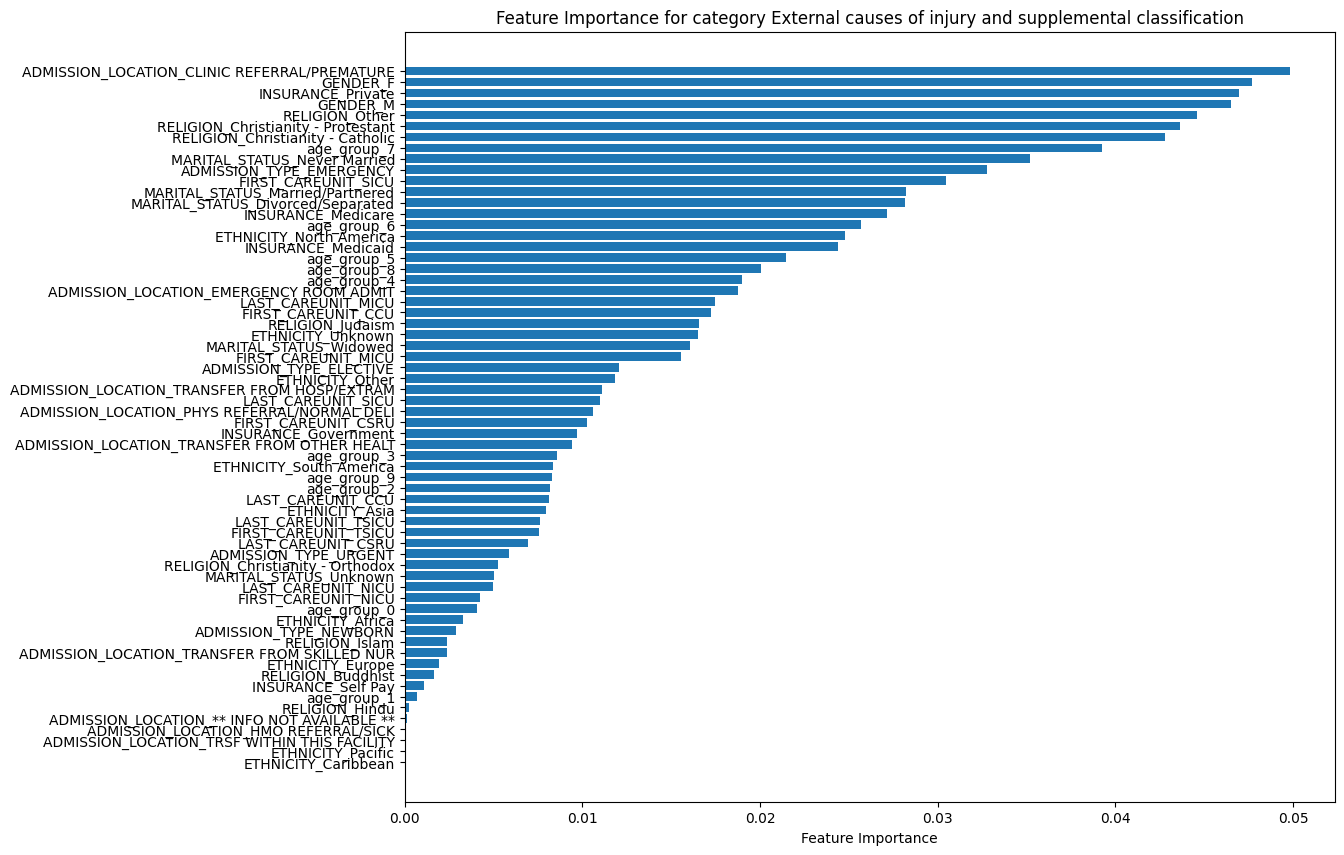

Number of trees in the forest for category External causes of injury and supplemental classification: 100
Category: Other
Mean Absolute Error: 6.166557828158077
Mean Squared Error: 143.82665280963022
Root Mean Squared Error: 11.992775025390504
Feature Importances for category Other:
                                         Feature    Importance
8   ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI  7.843763e-02
51                            LAST_CAREUNIT_NICU  7.768303e-02
19              RELIGION_Christianity - Catholic  5.552234e-02
45                           FIRST_CAREUNIT_NICU  5.521071e-02
14                            INSURANCE_Medicaid  5.408767e-02
..                                           ...           ...
55                                   age_group_1  7.216546e-05
22                                RELIGION_Hindu  1.790698e-05
33                           ETHNICITY_Caribbean  1.242855e-07
37                             ETHNICITY_Pacific  0.000000e+00
12  ADMISSION_LOCATION_

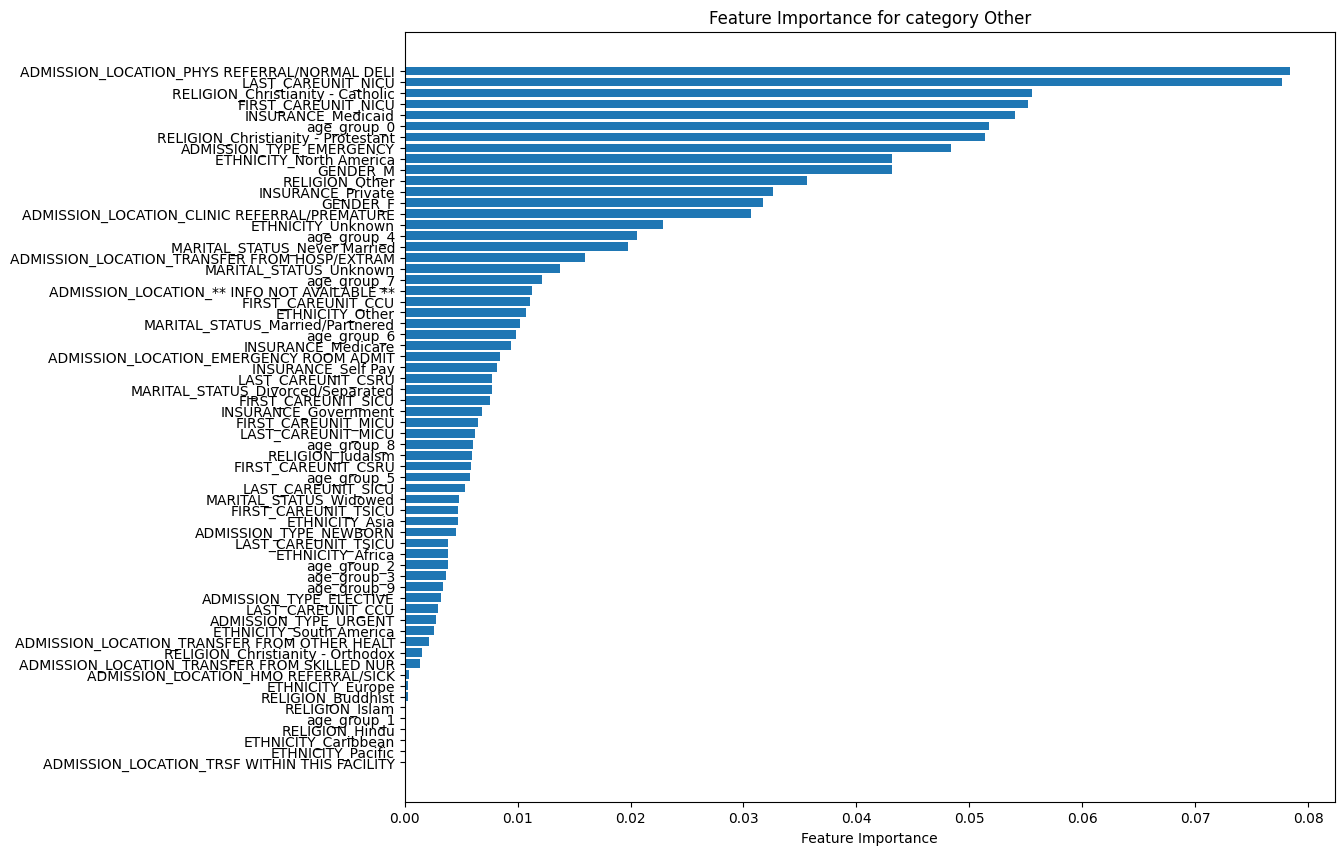

Number of trees in the forest for category Other: 100
Category: Diseases of the digestive system
Mean Absolute Error: 4.580466307234073
Mean Squared Error: 66.01811639048655
Root Mean Squared Error: 8.125153314891145
Feature Importances for category Diseases of the digestive system:
                                         Feature  Importance
21            RELIGION_Christianity - Protestant    0.044608
19              RELIGION_Christianity - Catholic    0.040436
40                                      GENDER_F    0.039798
41                                      GENDER_M    0.039239
47                          FIRST_CAREUNIT_TSICU    0.039237
..                                           ...         ...
33                           ETHNICITY_Caribbean    0.000007
37                             ETHNICITY_Pacific    0.000006
4    ADMISSION_LOCATION_** INFO NOT AVAILABLE **    0.000005
12  ADMISSION_LOCATION_TRSF WITHIN THIS FACILITY    0.000005
7           ADMISSION_LOCATION_HMO REFERRAL/S

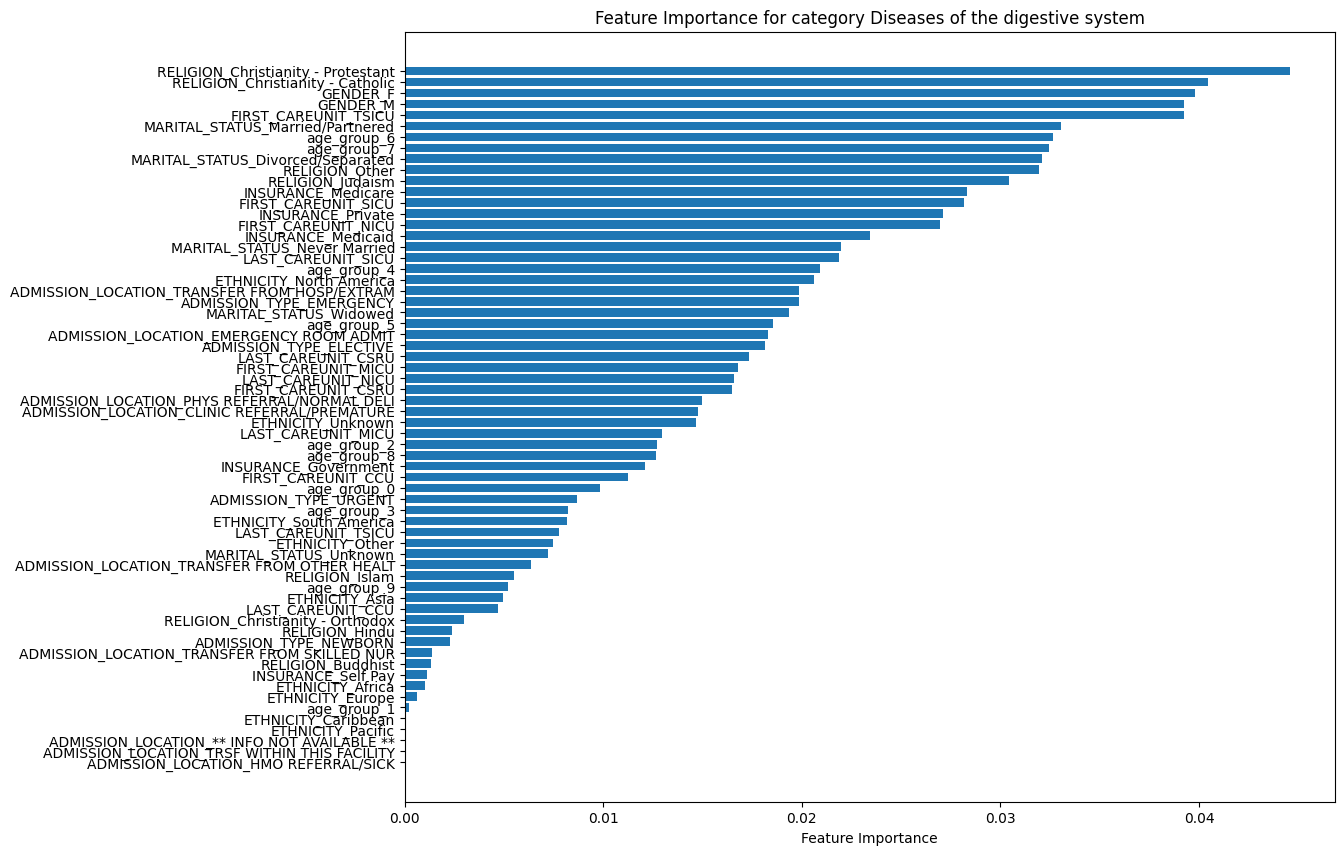

Number of trees in the forest for category Diseases of the digestive system: 100
Category: Diseases of the nervous system and sense organs
Mean Absolute Error: 4.126303284917482
Mean Squared Error: 53.47167702619679
Root Mean Squared Error: 7.312433044219741
Feature Importances for category Diseases of the nervous system and sense organs:
                                         Feature  Importance
45                           FIRST_CAREUNIT_NICU    0.062407
58                                   age_group_4    0.048150
21            RELIGION_Christianity - Protestant    0.042010
28                  MARITAL_STATUS_Never Married    0.038470
51                            LAST_CAREUNIT_NICU    0.037967
..                                           ...         ...
12  ADMISSION_LOCATION_TRSF WITHIN THIS FACILITY    0.000060
33                           ETHNICITY_Caribbean    0.000045
37                             ETHNICITY_Pacific    0.000035
7           ADMISSION_LOCATION_HMO REFERRAL/SICK 

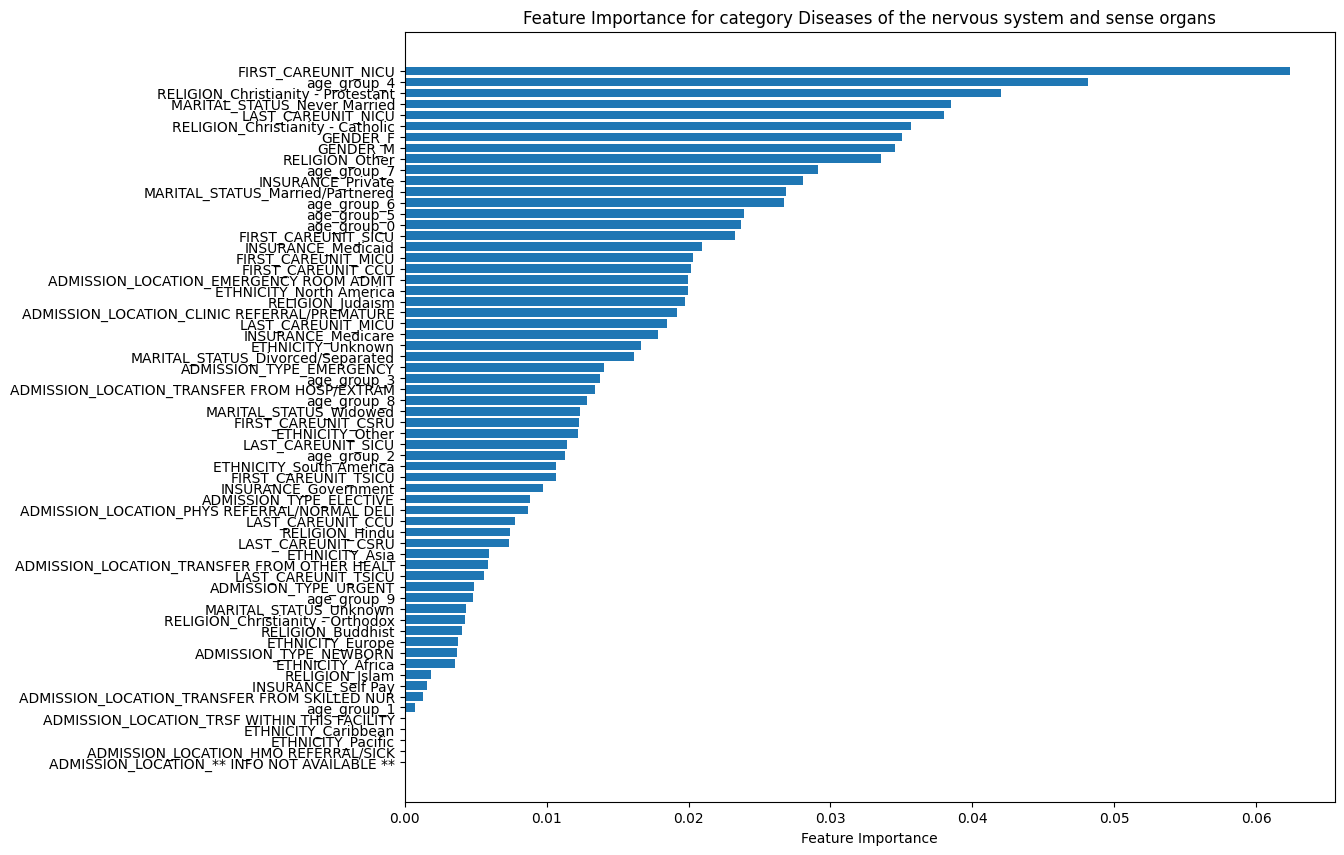

Number of trees in the forest for category Diseases of the nervous system and sense organs: 100
Category: Symptoms, signs, and ill-defined conditions
Mean Absolute Error: 4.307121671696048
Mean Squared Error: 52.11933001309235
Root Mean Squared Error: 7.219371857238852
Feature Importances for category Symptoms, signs, and ill-defined conditions:
                                         Feature    Importance
16                             INSURANCE_Private  3.942400e-02
60                                   age_group_6  3.845266e-02
21            RELIGION_Christianity - Protestant  3.725882e-02
40                                      GENDER_F  3.697616e-02
41                                      GENDER_M  3.650360e-02
..                                           ...           ...
12  ADMISSION_LOCATION_TRSF WITHIN THIS FACILITY  2.156503e-05
4    ADMISSION_LOCATION_** INFO NOT AVAILABLE **  8.155658e-06
33                           ETHNICITY_Caribbean  2.893009e-06
37                    

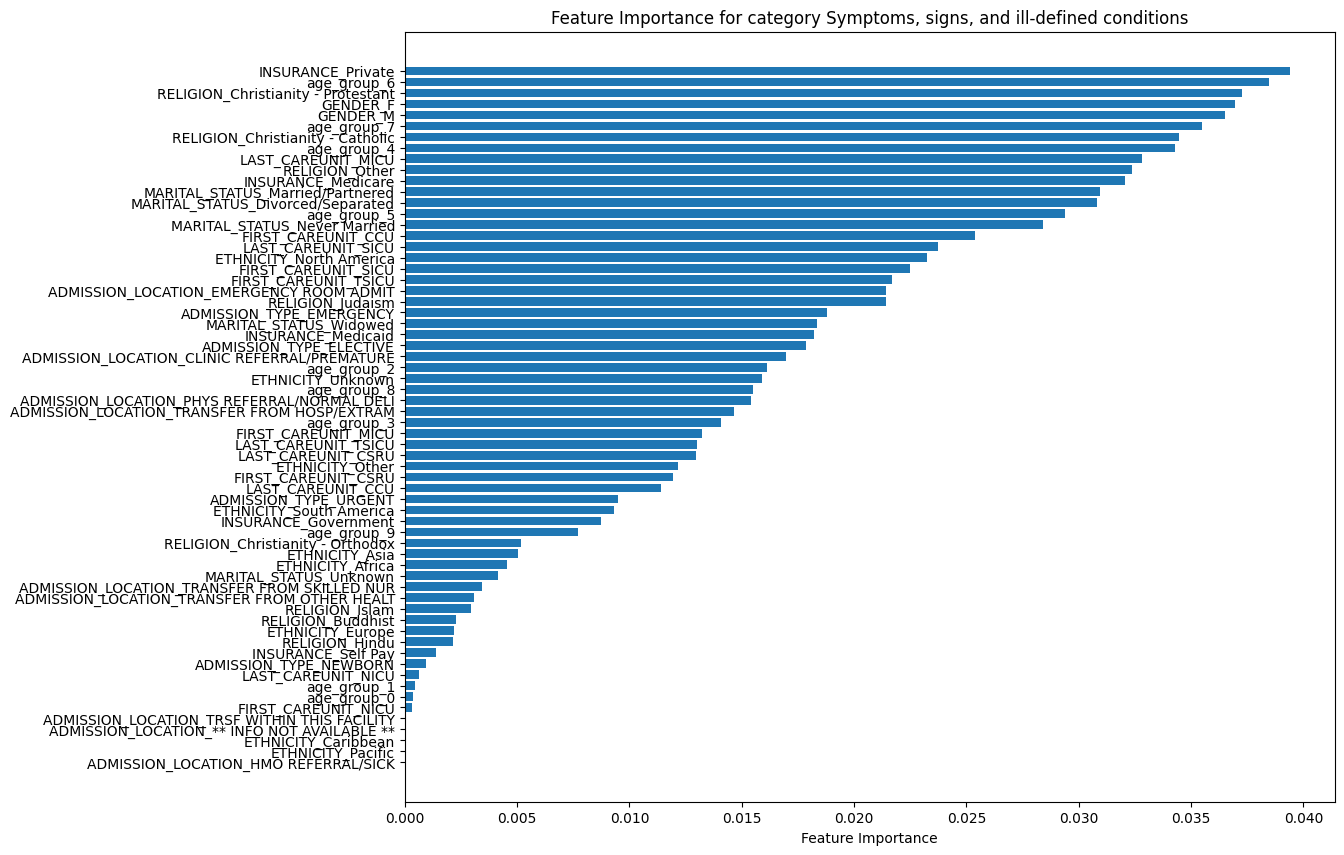

Number of trees in the forest for category Symptoms, signs, and ill-defined conditions: 100
Category: Diseases of the genitourinary system
Mean Absolute Error: 4.368207560892797
Mean Squared Error: 57.23827747177196
Root Mean Squared Error: 7.565598289082758
Feature Importances for category Diseases of the genitourinary system:
                                         Feature  Importance
40                                      GENDER_F    0.043799
41                                      GENDER_M    0.041520
21            RELIGION_Christianity - Protestant    0.040314
19              RELIGION_Christianity - Catholic    0.037451
27              MARITAL_STATUS_Married/Partnered    0.035279
..                                           ...         ...
37                             ETHNICITY_Pacific    0.000019
12  ADMISSION_LOCATION_TRSF WITHIN THIS FACILITY    0.000010
33                           ETHNICITY_Caribbean    0.000009
4    ADMISSION_LOCATION_** INFO NOT AVAILABLE **    0.000005

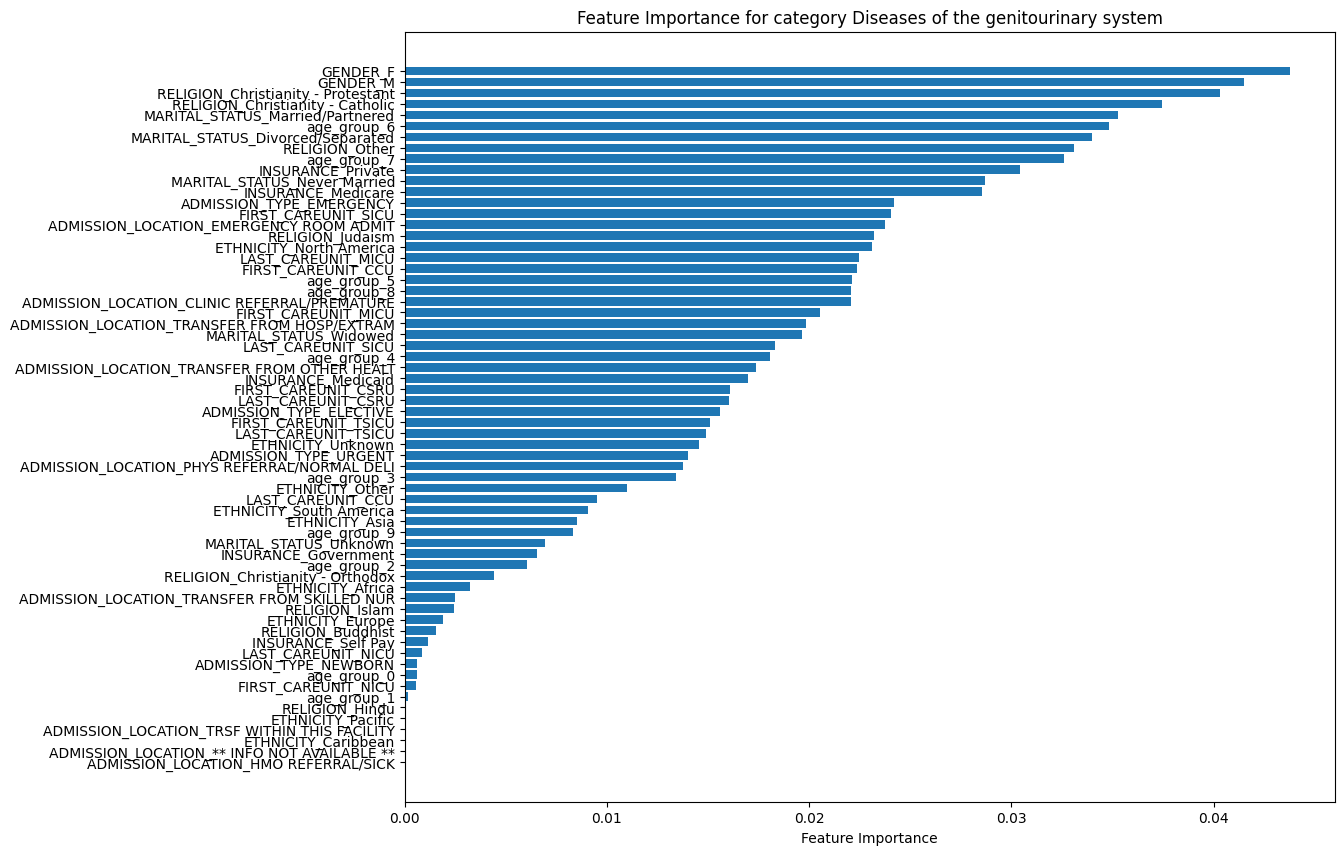

Number of trees in the forest for category Diseases of the genitourinary system: 100
Category: Endocrine, nutritional and metabolic diseases, and immunity disorders
Mean Absolute Error: 3.6972974591535896
Mean Squared Error: 41.59583171892405
Root Mean Squared Error: 6.449483058270953
Feature Importances for category Endocrine, nutritional and metabolic diseases, and immunity disorders:
                                         Feature  Importance
61                                   age_group_7    0.055111
41                                      GENDER_M    0.042121
16                             INSURANCE_Private    0.040647
40                                      GENDER_F    0.040623
15                            INSURANCE_Medicare    0.037120
..                                           ...         ...
33                           ETHNICITY_Caribbean    0.000060
4    ADMISSION_LOCATION_** INFO NOT AVAILABLE **    0.000011
37                             ETHNICITY_Pacific    0.000010


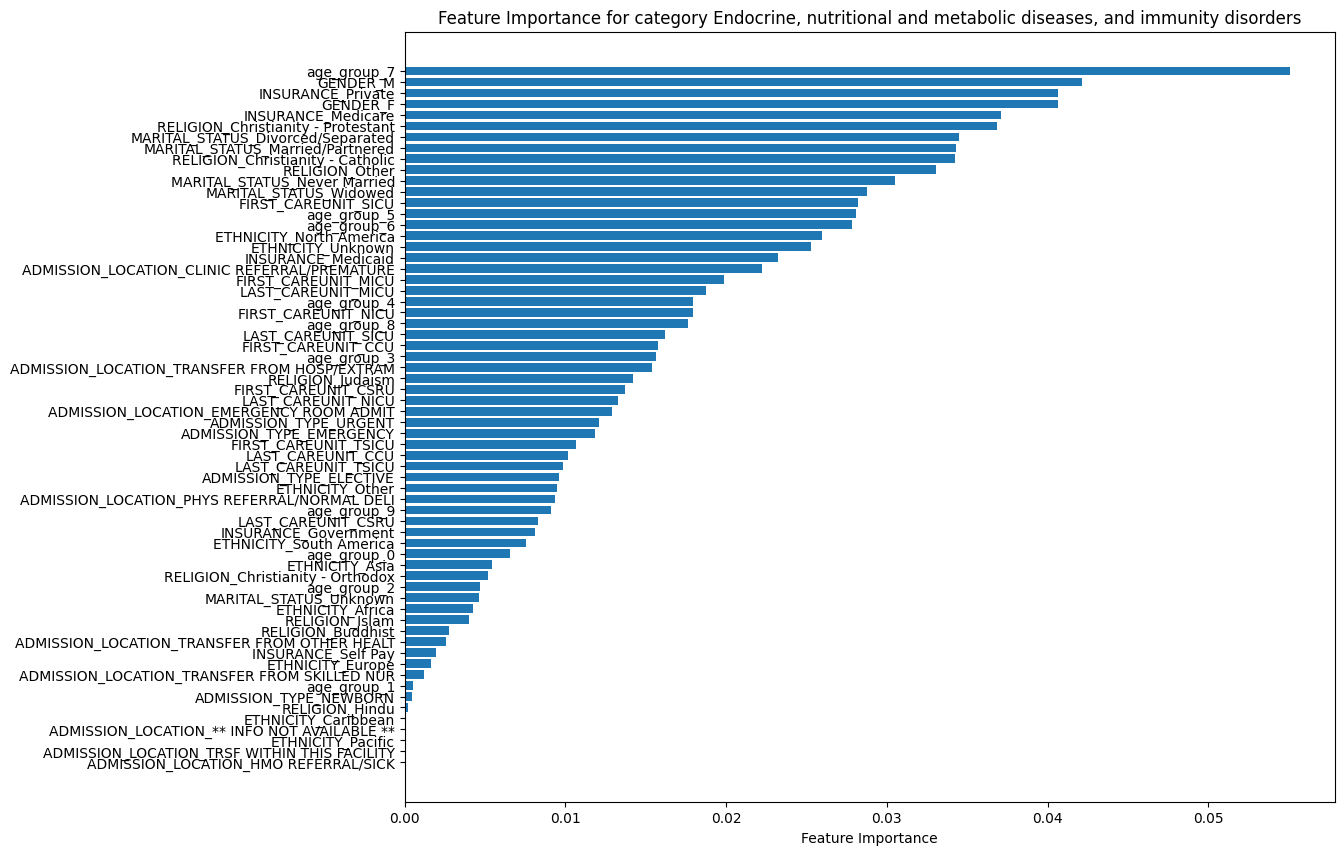

Number of trees in the forest for category Endocrine, nutritional and metabolic diseases, and immunity disorders: 100
Category: Diseases of the respiratory system
Mean Absolute Error: 5.533854562359171
Mean Squared Error: 74.7894529009216
Root Mean Squared Error: 8.648089552087304
Feature Importances for category Diseases of the respiratory system:
                                 Feature    Importance
40                              GENDER_F  5.590125e-02
41                              GENDER_M  5.266736e-02
21    RELIGION_Christianity - Protestant  4.029068e-02
26     MARITAL_STATUS_Divorced/Separated  3.776742e-02
25                        RELIGION_Other  3.703895e-02
..                                   ...           ...
51                    LAST_CAREUNIT_NICU  2.599564e-06
45                   FIRST_CAREUNIT_NICU  2.137541e-06
54                           age_group_0  6.293695e-07
7   ADMISSION_LOCATION_HMO REFERRAL/SICK  0.000000e+00
2                 ADMISSION_TYPE_NEWBORN  0.

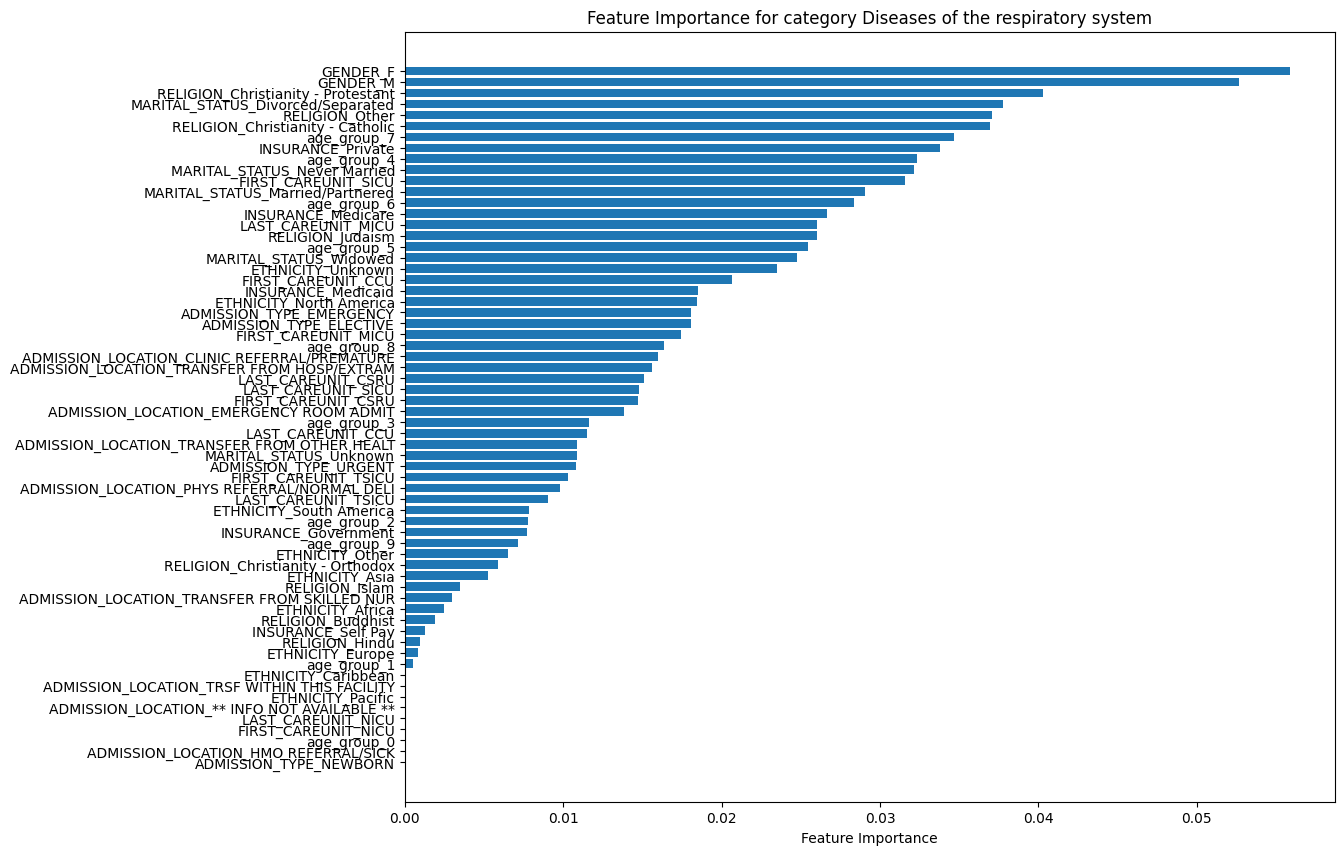

Number of trees in the forest for category Diseases of the respiratory system: 100
Category: Infectious and parasitic diseases
Mean Absolute Error: 5.757688879316126
Mean Squared Error: 87.94277505323902
Root Mean Squared Error: 9.377780923717456
Feature Importances for category Infectious and parasitic diseases:
                                         Feature  Importance
58                                   age_group_4    0.066991
41                                      GENDER_M    0.038374
40                                      GENDER_F    0.038051
19              RELIGION_Christianity - Catholic    0.037581
21            RELIGION_Christianity - Protestant    0.035237
..                                           ...         ...
37                             ETHNICITY_Pacific    0.000039
33                           ETHNICITY_Caribbean    0.000015
12  ADMISSION_LOCATION_TRSF WITHIN THIS FACILITY    0.000009
4    ADMISSION_LOCATION_** INFO NOT AVAILABLE **    0.000001
7           AD

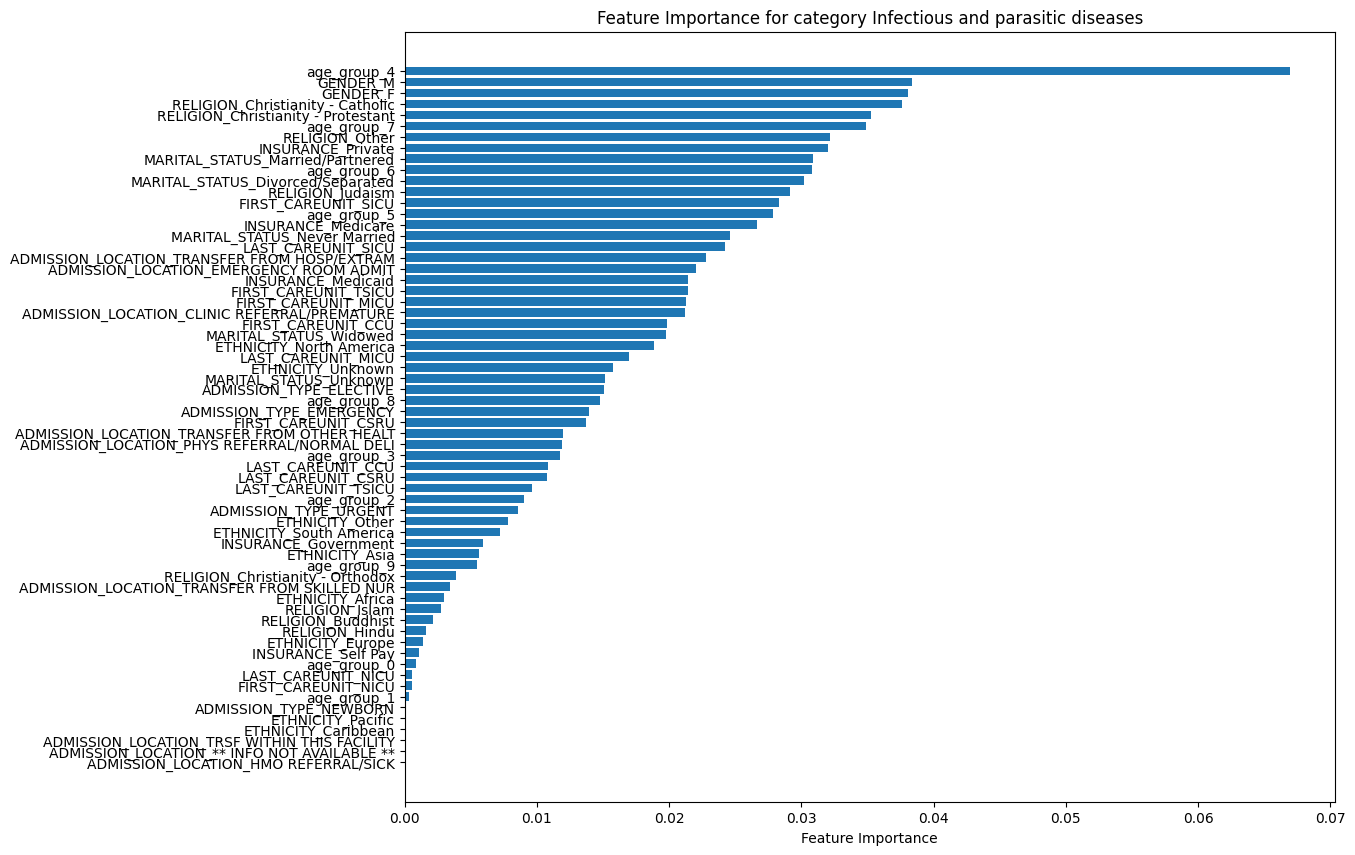

Number of trees in the forest for category Infectious and parasitic diseases: 100
Category: Diseases of the circulatory system
Mean Absolute Error: 3.601453673599393
Mean Squared Error: 44.923906856358975
Root Mean Squared Error: 6.702529884779252
Feature Importances for category Diseases of the circulatory system:
                                         Feature  Importance
40                                      GENDER_F    0.054202
19              RELIGION_Christianity - Catholic    0.046806
41                                      GENDER_M    0.046705
58                                   age_group_4    0.044231
25                                RELIGION_Other    0.042773
..                                           ...         ...
2                         ADMISSION_TYPE_NEWBORN    0.000023
37                             ETHNICITY_Pacific    0.000017
4    ADMISSION_LOCATION_** INFO NOT AVAILABLE **    0.000011
12  ADMISSION_LOCATION_TRSF WITHIN THIS FACILITY    0.000003
7           

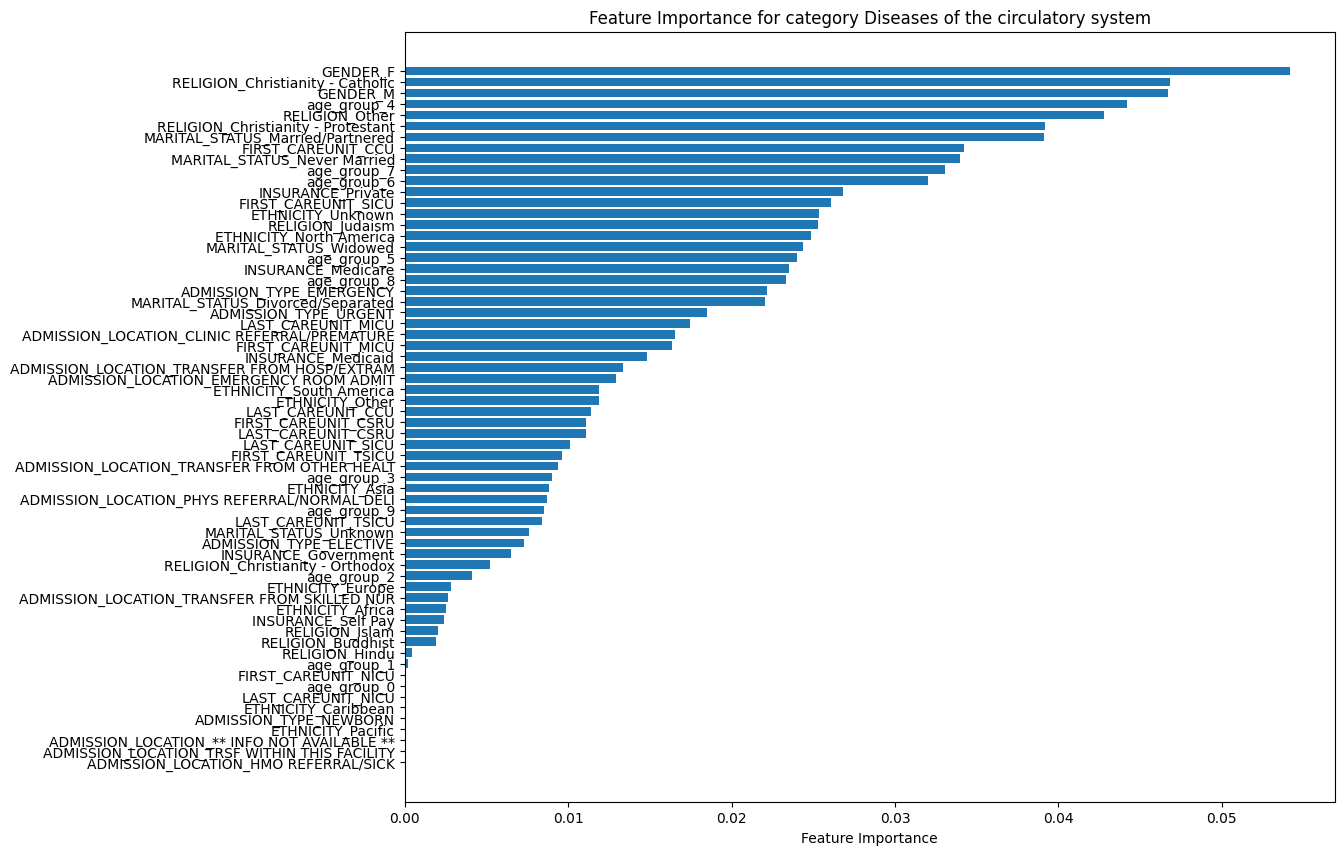

Number of trees in the forest for category Diseases of the circulatory system: 100
Category: Injury and poisoning
Mean Absolute Error: 5.456555184056556
Mean Squared Error: 99.01221486583972
Root Mean Squared Error: 9.950488172237568
Feature Importances for category Injury and poisoning:
                                        Feature  Importance
21           RELIGION_Christianity - Protestant    0.043351
25                               RELIGION_Other    0.040096
16                            INSURANCE_Private    0.038775
61                                  age_group_7    0.036493
19             RELIGION_Christianity - Catholic    0.035711
..                                          ...         ...
37                            ETHNICITY_Pacific    0.000030
33                          ETHNICITY_Caribbean    0.000003
4   ADMISSION_LOCATION_** INFO NOT AVAILABLE **    0.000001
2                        ADMISSION_TYPE_NEWBORN    0.000001
7          ADMISSION_LOCATION_HMO REFERRAL/SICK    

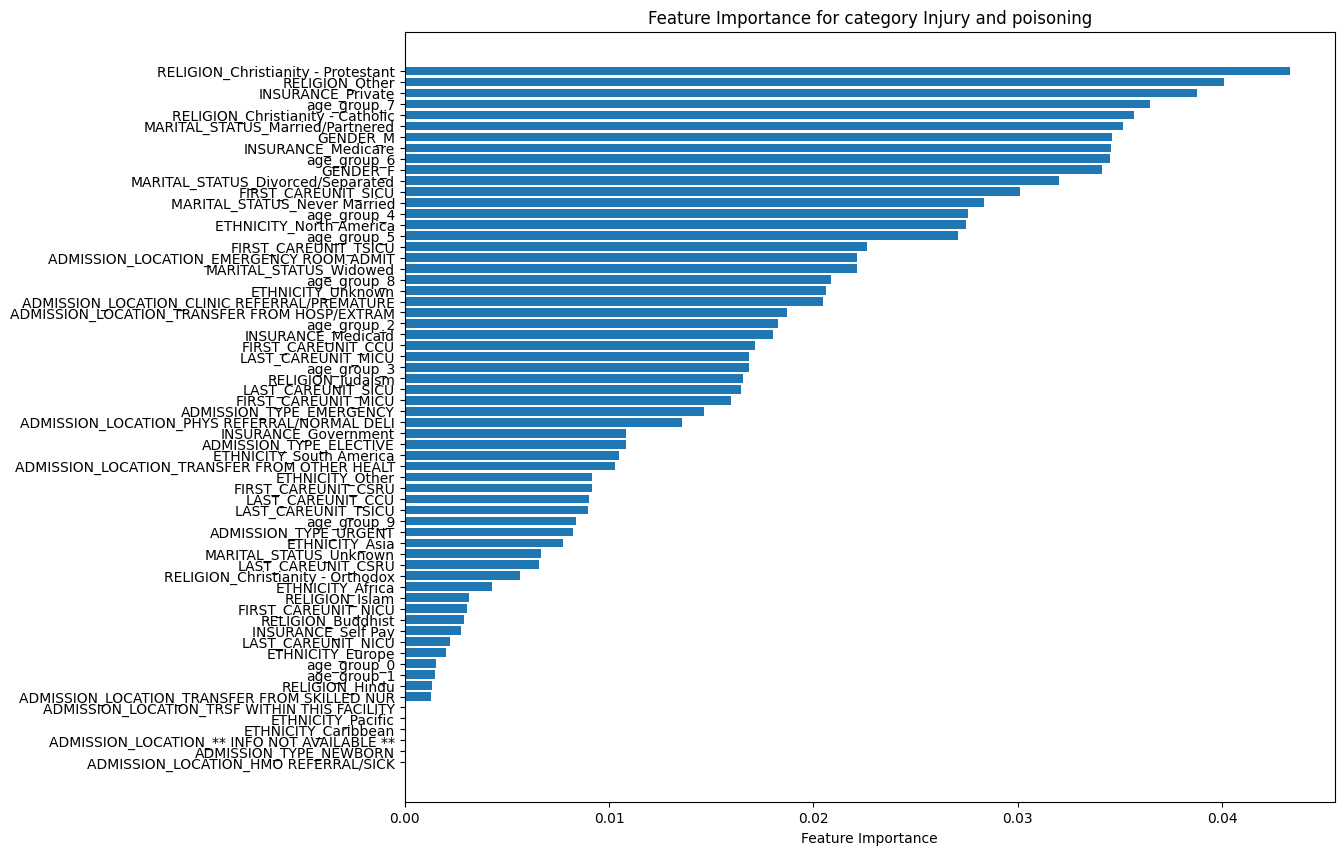

Number of trees in the forest for category Injury and poisoning: 100
Category: Mental disorders
Mean Absolute Error: 3.5586245381905783
Mean Squared Error: 39.66769403822499
Root Mean Squared Error: 6.2982294367722895
Feature Importances for category Mental disorders:
                                 Feature  Importance
40                              GENDER_F    0.048788
41                              GENDER_M    0.048400
19      RELIGION_Christianity - Catholic    0.045210
28          MARITAL_STATUS_Never Married    0.040914
27      MARITAL_STATUS_Married/Partnered    0.038461
..                                   ...         ...
2                 ADMISSION_TYPE_NEWBORN    0.000000
45                   FIRST_CAREUNIT_NICU    0.000000
7   ADMISSION_LOCATION_HMO REFERRAL/SICK    0.000000
51                    LAST_CAREUNIT_NICU    0.000000
54                           age_group_0    0.000000

[64 rows x 2 columns]


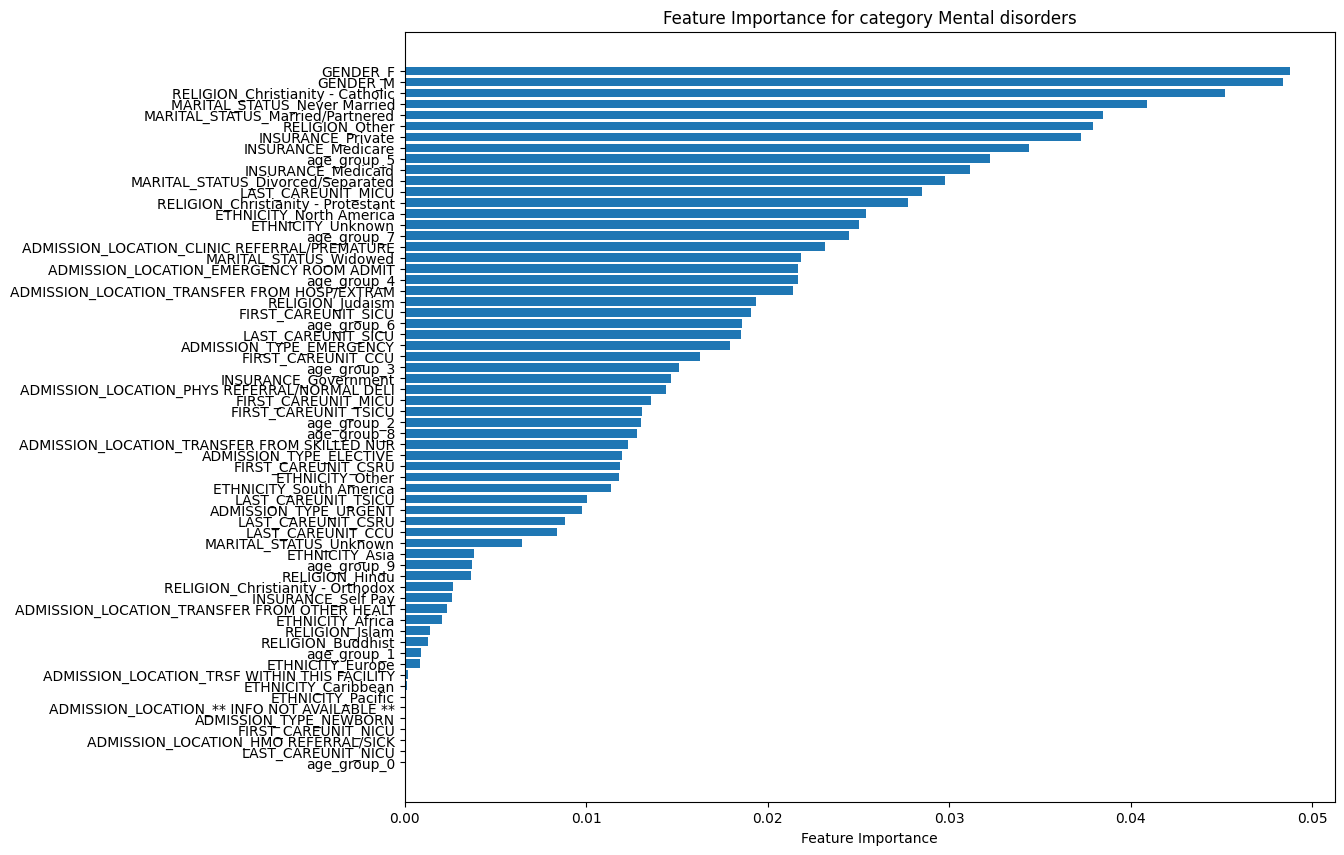

Number of trees in the forest for category Mental disorders: 100
Category: Neoplasms
Mean Absolute Error: 3.462986203574076
Mean Squared Error: 40.57177132042361
Root Mean Squared Error: 6.369597422162848
Feature Importances for category Neoplasms:
                                        Feature  Importance
40                                     GENDER_F    0.043443
27             MARITAL_STATUS_Married/Partnered    0.042815
41                                     GENDER_M    0.041759
19             RELIGION_Christianity - Catholic    0.040411
28                 MARITAL_STATUS_Never Married    0.038713
..                                          ...         ...
45                          FIRST_CAREUNIT_NICU    0.000000
7          ADMISSION_LOCATION_HMO REFERRAL/SICK    0.000000
33                          ETHNICITY_Caribbean    0.000000
4   ADMISSION_LOCATION_** INFO NOT AVAILABLE **    0.000000
2                        ADMISSION_TYPE_NEWBORN    0.000000

[64 rows x 2 columns]


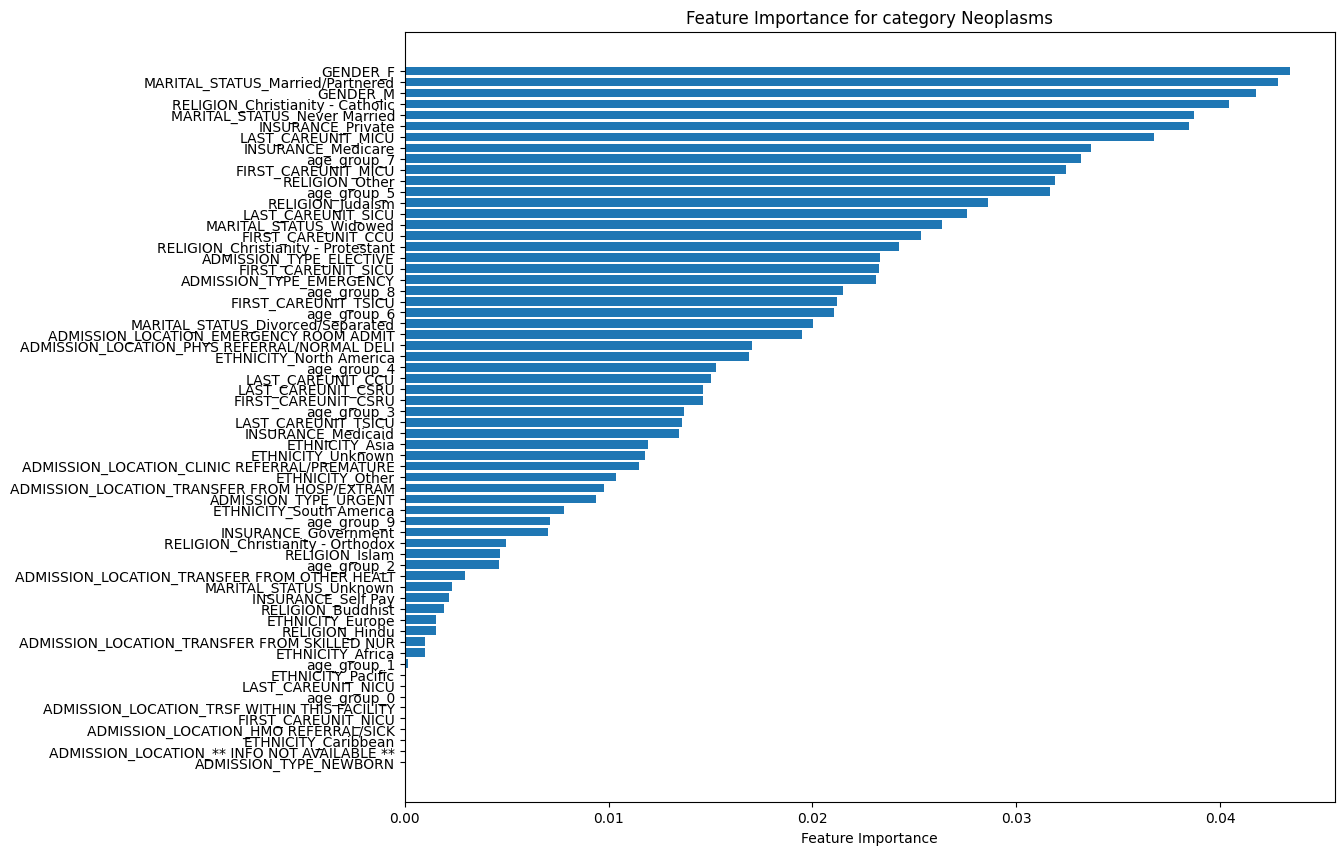

Number of trees in the forest for category Neoplasms: 100
Category: Diseases of the blood and blood-forming organs
Mean Absolute Error: 4.4948691180259885
Mean Squared Error: 62.17710699056151
Root Mean Squared Error: 7.885246159160887
Feature Importances for category Diseases of the blood and blood-forming organs:
                                         Feature  Importance
26             MARITAL_STATUS_Divorced/Separated    0.051836
41                                      GENDER_M    0.044444
40                                      GENDER_F    0.043258
58                                   age_group_4    0.039365
27              MARITAL_STATUS_Married/Partnered    0.037036
..                                           ...         ...
33                           ETHNICITY_Caribbean    0.000038
12  ADMISSION_LOCATION_TRSF WITHIN THIS FACILITY    0.000021
37                             ETHNICITY_Pacific    0.000016
4    ADMISSION_LOCATION_** INFO NOT AVAILABLE **    0.000004
7           

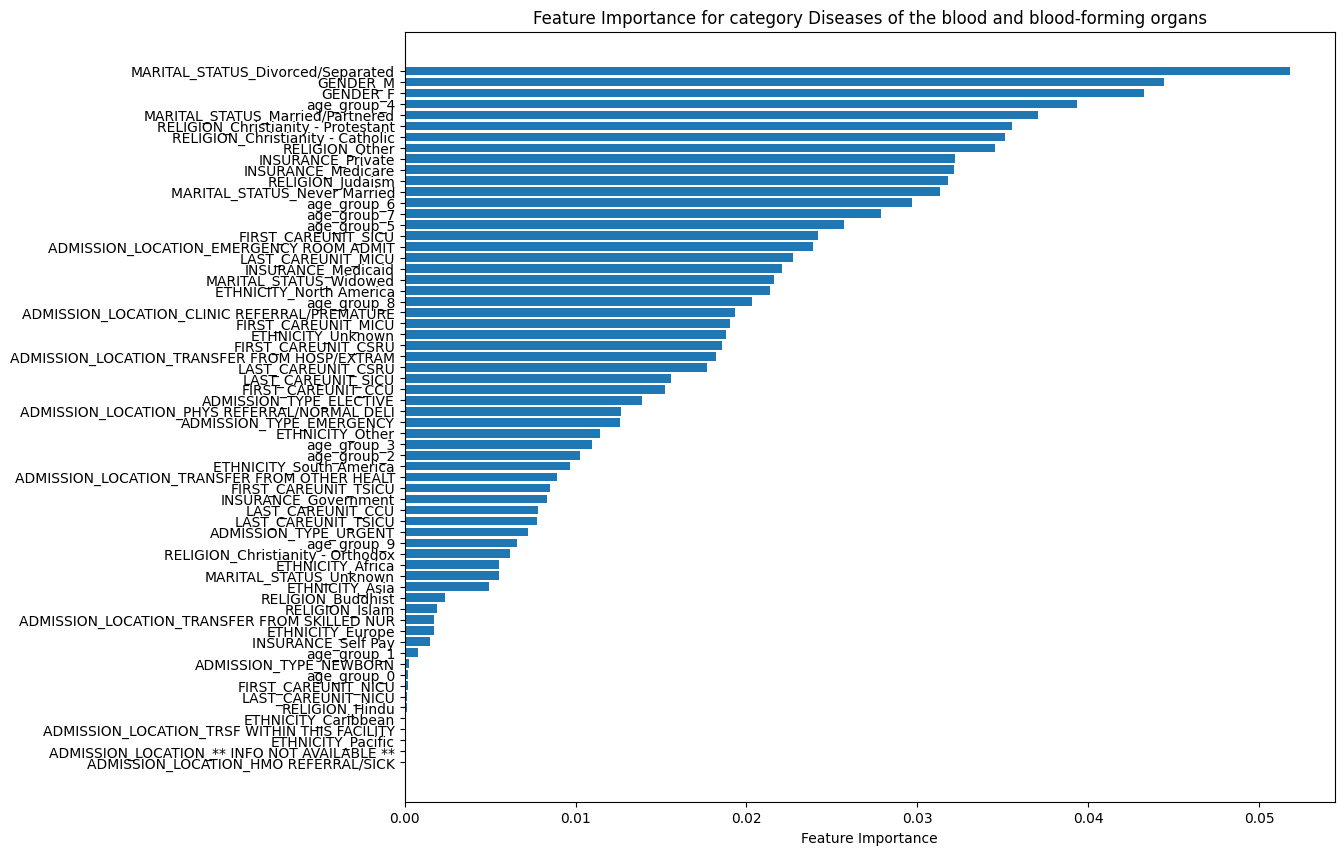

Number of trees in the forest for category Diseases of the blood and blood-forming organs: 100
Category: Diseases of the musculoskeletal system and connective tissue
Mean Absolute Error: 3.3926481752764652
Mean Squared Error: 40.76567911015124
Root Mean Squared Error: 6.3848006319814905
Feature Importances for category Diseases of the musculoskeletal system and connective tissue:
                                         Feature    Importance
28                  MARITAL_STATUS_Never Married  4.164605e-02
19              RELIGION_Christianity - Catholic  3.932783e-02
40                                      GENDER_F  3.675122e-02
27              MARITAL_STATUS_Married/Partnered  3.673507e-02
25                                RELIGION_Other  3.645867e-02
..                                           ...           ...
4    ADMISSION_LOCATION_** INFO NOT AVAILABLE **  1.986132e-06
51                            LAST_CAREUNIT_NICU  1.440612e-06
33                           ETHNICITY_Caribbean  

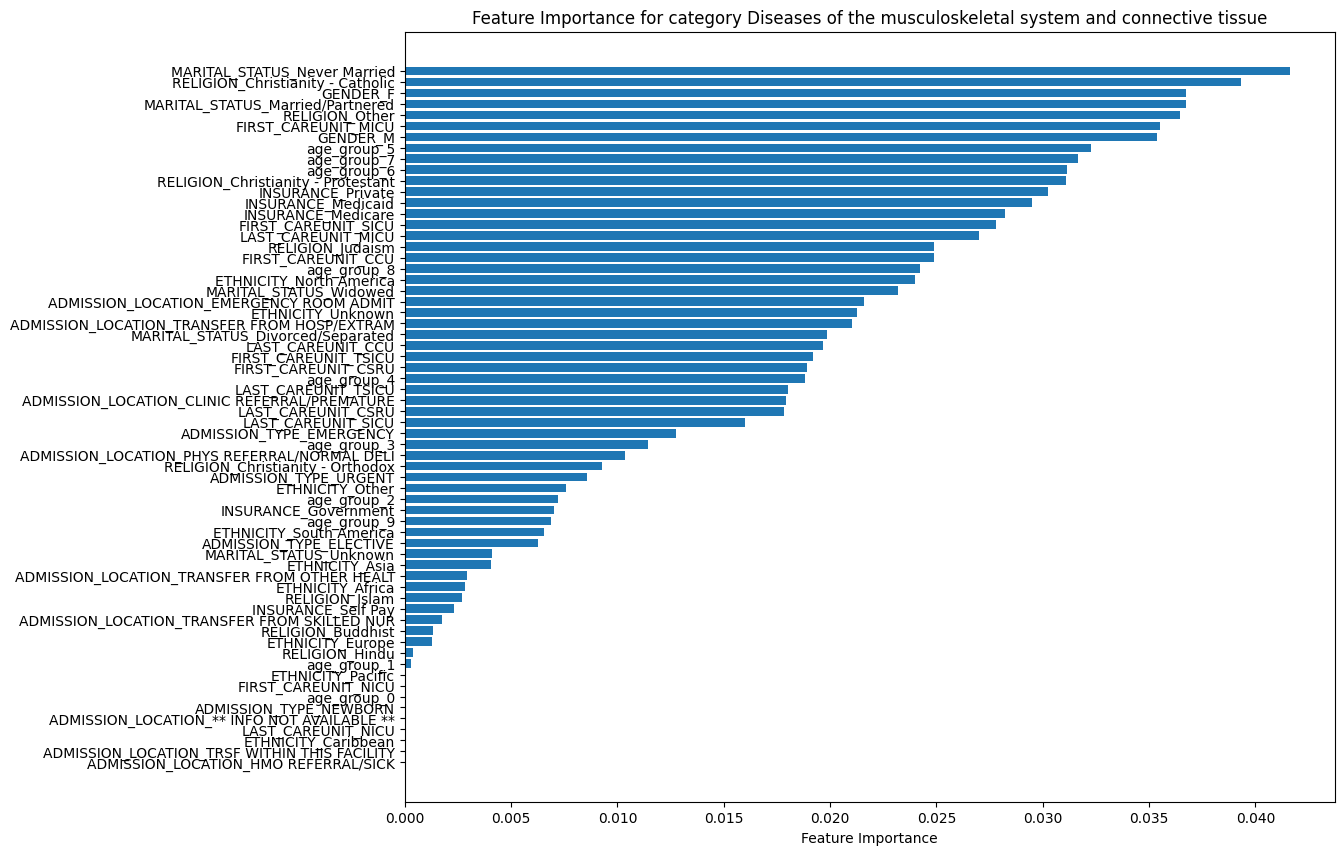

Number of trees in the forest for category Diseases of the musculoskeletal system and connective tissue: 100


In [ ]:
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.wrappers import ParallelPostFit
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Assuming dfs_by_category is your dictionary of Dask DataFrames categorized by ICD9_Category
models = {}

# Iterate over each category and its corresponding DataFrame
for category, df_category in dfs_by_category.items():
    # Drop the ICD9_Category column from the features
    df_category = df_category.drop(columns=['ICD9_Category'])

    # Ensure there are enough samples to split into train and test sets
    if df_category.shape[0].compute() < 2:
        print(f"Not enough samples for category {category}. Skipping...")
        continue

    categorical_features = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
                            'ETHNICITY', 'GENDER', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'age_group']

    # One-hot encode categorical columns excluding 'LOS'
    df_category_encoded = dd.get_dummies(df_category, columns=categorical_features)
    # Get unique subject IDs
    unique_subject_ids = df_category_encoded['SUBJECT_ID'].unique().compute()

    # Perform train-test split on the unique subject IDs
    train_subjects, test_subjects = train_test_split(unique_subject_ids, test_size=0.2, random_state=42)

    # Convert to Dask DataFrames
    train_subjects_dd = dd.from_pandas(pd.Series(train_subjects), npartitions=10)
    test_subjects_dd = dd.from_pandas(pd.Series(test_subjects), npartitions=10)

    # Filter the original DataFrame to create training and test sets
    X_train_ddf = df_category_encoded[df_category_encoded['SUBJECT_ID'].isin(train_subjects)]
    X_test_ddf = df_category_encoded[df_category_encoded['SUBJECT_ID'].isin(test_subjects)]

    # Ensure the target variable is separate
    y_train = X_train_ddf['LOS']
    y_test = X_test_ddf['LOS']
    X_train = X_train_ddf.drop(columns=['LOS','SUBJECT_ID','HADM_ID', 'ICUSTAY_ID'])
    X_test = X_test_ddf.drop(columns=['LOS','SUBJECT_ID','HADM_ID', 'ICUSTAY_ID'])

    model = Pipeline([
        ('regressor', ParallelPostFit(estimator=RandomForestRegressor(n_estimators=100, random_state=42)))
    ])

    # Training the model
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test).compute()

    # Evaluating the model
    y_test = y_test.compute()
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print(f'Category: {category}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')

    # Extract the underlying RandomForestRegressor from the pipeline
    rf_model = model.named_steps['regressor'].estimator

    # Get feature importances
    feature_importances = rf_model.feature_importances_
    feature_names = list(X_train.columns)

    # Create a DataFrame for the feature importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(f'Feature Importances for category {category}:')
    print(feature_importance_df)

    # Plot feature importances
    plt.figure(figsize=(12, 10))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for category {category}')
    plt.gca().invert_yaxis()
    plt.show()

    # Get the number of trees in the forest
    num_trees = rf_model.n_estimators
    print(f'Number of trees in the forest for category {category}: {num_trees}')

    # Store the model and metrics for this category
    models[category] = {
        'model': model,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'feature_importance': feature_importance_df,
        'num_trees': num_trees
    }

---------------------------------------------------------------------------------------------------------

We can see that the results vary from 3.39 to 6.16 and the mean of the absolute error is 4.41. The importance of the features follow roughly the same distribution for all the models. We can also see that some of the most important columns are the genders the age groups and the religion of the patient.

# APPROACH 4
## We were not satisfied with the results, so we decided to use patient measures of the top 10 ITEMID's (by frequency)
### After that, we defined manually, for each itemID, the range of the values that is defined to be a healthy value and the unhealthy, so we have a good interpretation for our model

## Data processing and grouping

In [ ]:
query = f"""
CREATE OR REPLACE TABLE DATASET.PROCESSED AS
SELECT
    i.SUBJECT_ID,
    i.HADM_ID,
    i.ICUSTAY_ID,
    a.ADMISSION_TYPE,
    a.ADMISSION_LOCATION,
    a.INSURANCE,
    CASE
        WHEN a.RELIGION IN ('7TH DAY ADVENTIST', 'BAPTIST', 'CHRISTIAN SCIENTIST', 'EPISCOPALIAN', 'LUTHERAN', 'METHODIST', 'PROTESTANT QUAKER', 'UNITARIAN-UNIVERSALIST') THEN 'Christianity - Protestant'
        WHEN a.RELIGION IN ('CATHOLIC') THEN 'Christianity - Catholic'
        WHEN a.RELIGION IN ('GREEK ORTHODOX', 'ROMANIAN EAST. ORTH') THEN 'Christianity - Orthodox'
        WHEN a.RELIGION IN ('HEBREW', 'JEWISH') THEN 'Judaism'
        WHEN a.RELIGION = 'MUSLIM' THEN 'Islam'
        WHEN a.RELIGION = 'BUDDHIST' THEN 'Buddhist'
        WHEN a.RELIGION = 'HINDU' THEN 'Hindu'
        WHEN a.RELIGION = 'OTHER' THEN 'Other'
        ELSE 'Other'
    END AS RELIGION,
    CASE
        WHEN a.MARITAL_STATUS = 'DIVORCED' THEN 'Divorced/Separated'
        WHEN a.MARITAL_STATUS = 'SEPARATED' THEN 'Divorced/Separated'
        WHEN a.MARITAL_STATUS = 'LIFE PARTNER' THEN 'Married/Partnered'
        WHEN a.MARITAL_STATUS = 'MARRIED' THEN 'Married/Partnered'
        WHEN a.MARITAL_STATUS = 'SINGLE' THEN 'Never Married'
        WHEN a.MARITAL_STATUS = 'WIDOWED' THEN 'Widowed'
        WHEN a.MARITAL_STATUS = 'UNKNOWN (DEFAULT)' THEN 'Unknown'
        ELSE 'Unknown'
    END AS MARITAL_STATUS,
    CASE
        WHEN a.ETHNICITY IN ('AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 'WHITE', 'BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN') THEN 'North America'
        WHEN a.ETHNICITY IN ('ASIAN', 'ASIAN - ASIAN INDIAN', 'ASIAN - CAMBODIAN', 'ASIAN - CHINESE', 'ASIAN - FILIPINO', 'ASIAN - JAPANESE', 'ASIAN - KOREAN', 'ASIAN - OTHER', 'ASIAN - THAI', 'ASIAN - VIETNAMESE', 'MIDDLE EASTERN') THEN 'Asia'
        WHEN a.ETHNICITY IN ('BLACK/CAPE VERDEAN', 'BLACK/HAITIAN') THEN 'Africa'
        WHEN a.ETHNICITY IN ('WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN') THEN 'Europe'
        WHEN a.ETHNICITY IN ('HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - SALVADORAN', 'SOUTH AMERICAN') THEN 'South America'
        WHEN a.ETHNICITY = 'CARIBBEAN ISLAND' THEN 'Caribbean'
        WHEN a.ETHNICITY = 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' THEN 'Pacific'
        WHEN a.ETHNICITY IN ('MULTI RACE ETHNICITY', 'PORTUGUESE', 'OTHER') THEN 'Other'
        ELSE 'Unknown'
    END AS ETHNICITY,
    p.GENDER,
    diag.ICD9_CODE,
    diag2.SHORT_TITLE,
    i.FIRST_CAREUNIT,
    i.LAST_CAREUNIT,
    i.LOS,
    CASE
        WHEN EXTRACT(YEAR FROM a.ADMITTIME) - EXTRACT(YEAR FROM p.DOB) > 299 THEN 91
        ELSE EXTRACT(YEAR FROM a.ADMITTIME) - EXTRACT(YEAR FROM p.DOB)
    END AS age
FROM
    DATASET.ICUSTAYS_CLEAN i
JOIN
    DATASET.ADMISSIONS_CLEAN a ON i.SUBJECT_ID = a.SUBJECT_ID AND i.HADM_ID = a.HADM_ID
JOIN
    DATASET.PATIENTS_CLEAN p ON i.SUBJECT_ID = p.SUBJECT_ID
JOIN
    DATASET.DIAGNOSES_ICD_CLEAN diag ON i.SUBJECT_ID = diag.SUBJECT_ID AND i.HADM_ID = diag.HADM_ID
JOIN
    DATASET.DIAGNOSES_CLEAN diag2 ON diag.ICD9_CODE = diag2.ICD9_CODE
WHERE
    i.SUBJECT_ID IS NOT NULL AND
    i.HADM_ID IS NOT NULL AND
    i.ICUSTAY_ID IS NOT NULL AND
    a.ADMISSION_TYPE IS NOT NULL AND
    a.ADMISSION_LOCATION IS NOT NULL AND
    a.INSURANCE IS NOT NULL AND
    a.RELIGION IS NOT NULL AND
    a.MARITAL_STATUS IS NOT NULL AND
    a.ETHNICITY IS NOT NULL AND
    p.GENDER IS NOT NULL AND
    diag.ICD9_CODE IS NOT NULL AND
    diag2.SHORT_TITLE IS NOT NULL AND
    i.FIRST_CAREUNIT IS NOT NULL AND
    i.LAST_CAREUNIT IS NOT NULL AND
    i.LOS IS NOT NULL AND
    EXTRACT(YEAR FROM a.ADMITTIME) - EXTRACT(YEAR FROM p.DOB) IS NOT NULL AND
    diag.SEQ_NUM = 1;

"""
apply = client.query(query).to_dataframe()

In [ ]:
# Get the 10 most common Itemids
query="""
CREATE OR REPLACE TABLE `DATASET.JOINED_PROCESSED` AS
WITH ItemCounts AS (
    SELECT
        ITEMID,
        COUNT(*) AS item_count
    FROM
        `DATASET.CHARTEVENTS`
    WHERE
        VALUE IS NOT NULL
        AND VALUENUM IS NOT NULL
        AND ERROR = CAST(0 AS STRING)
        AND WARNING = CAST(0 AS STRING)
    GROUP BY
        ITEMID
    ORDER BY
        item_count DESC
    LIMIT 10
),
TopItemIDs AS (
    SELECT
        ITEMID
    FROM
        ItemCounts
),
FilteredChartevents AS (
    SELECT
        *
    FROM
        `DATASET.CHARTEVENTS`
    WHERE
        ITEMID IN (SELECT ITEMID FROM TopItemIDs)
        AND VALUE IS NOT NULL
        AND VALUENUM IS NOT NULL
        AND ERROR = CAST(0 AS STRING)
        AND WARNING = CAST(0 AS STRING)
)
SELECT
    c.ITEMID,
    c.VALUE,
    c.VALUENUM,
    p.*
FROM
    FilteredChartevents c
JOIN
    `DATASET.PROCESSED` p
ON
    CAST(c.SUBJECT_ID AS STRING) = CAST(p.SUBJECT_ID AS STRING)
    AND CAST(c.HADM_ID AS STRING) = CAST(p.HADM_ID AS STRING)
    AND CAST(c.ICUSTAY_ID AS STRING) = CAST(p.ICUSTAY_ID AS STRING);
"""
apply3 = client.query(query).to_dataframe()


Transform the table information into dataframe

In [ ]:
from dask_bigquery import read_gbq
import dask

# Define the project ID, dataset ID, and table ID

# Construct the query
query = f"SELECT * FROM `DATASET.JOINED_PROCESSED`"

# Read the BigQuery table into a Dask DataFrame
ddf = client.query(query).to_dataframe()
# Print the schema to verify

# Count the frequency of each ITEMID
itemid_counts = ddf['ITEMID'].value_counts()

# Get the top 10 ITEMIDs
top_10_itemids = itemid_counts.nlargest(10).index.tolist()
print("Top 10 ITEMIDs:", top_10_itemids)

# Filter the DataFrame
filtered_ddf = ddf[ddf['ITEMID'].isin(top_10_itemids)]

# Print some rows to verify
filtered_ddf.head()

Top 10 ITEMIDs: ['220045', '220210', '220277', '220181', '220179', '220180', '220052', '220050', '220051', '220739']


ITEMID VALUE VALUENUM  SUBJECT_ID  HADM_ID  ICUSTAY_ID ADMISSION_TYPE  \
0  220050   112      112       40548   168670      260223      EMERGENCY   
1  220210    28       28       40548   168670      260223      EMERGENCY   
2  220210    27       27       54595   110651      286192      EMERGENCY   
3  220179   121      121       49080   163099      231774      EMERGENCY   
4  220180    47       47       21538   187726      293821      EMERGENCY   

          ADMISSION_LOCATION INSURANCE                 RELIGION  \
0  CLINIC REFERRAL/PREMATURE  Medicare  Christianity - Catholic   
1  CLINIC REFERRAL/PREMATURE  Medicare  Christianity - Catholic   
2  CLINIC REFERRAL/PREMATURE   Private                    Other   
3  CLINIC REFERRAL/PREMATURE   Private  Christianity - Catholic   
4       EMERGENCY ROOM ADMIT  Medicare  Christianity - Catholic   

      MARITAL_STATUS      ETHNICITY GENDER ICD9_CODE  \
0  Married/Partnered  North America      F     99674   
1  Married/Partnered  North America      F     99674   
2  Married/Partnered  North America      F     82129   
3      Never Married  North America      M     85183   
4  Married/Partnered  South America      M     99811   

                SHORT_TITLE FIRST_CAREUNIT LAST_CAREUNIT      LOS  age  
0   Comp-oth vasc dev/graft           CSRU          CSRU  22.9123   74  
1   Comp-oth vasc dev/graft           CSRU          CSRU  22.9123   74  
2   Fx low end femur NEC-cl          TSICU         TSICU   9.7071   68  
3  Brain lacer NEC-mod coma          TSICU         TSICU   1.4748   19  
4   Hemorrhage complic proc           SICU          SICU   2.1100   49

In [ ]:
# Drop empty rows
filtered_ddf = filtered_ddf.dropna()

Get the max, min and average value of each measurement per patient

In [ ]:
filtered_ddf['VALUENUM'] = filtered_ddf['VALUENUM'].str.replace(r'[^0-9.-]', '')

# Convert VALUENUM column to numeric
filtered_ddf['VALUENUM'] = pd.to_numeric(filtered_ddf['VALUENUM'], errors='coerce')

# Group by SUBJECT_ID and ITEMID, then aggregate VALUENUM
result = filtered_ddf.groupby(['SUBJECT_ID', 'ITEMID']).agg({
    'VALUENUM': ['min', 'mean', 'max'], # Aggregation for VALUENUM
    'VALUE': 'first',                   # Keep the first value of VALUE
    'HADM_ID': 'first',                 # Keep the first value of HADM_ID
    'ICUSTAY_ID': 'first',              # Keep the first value of ICUSTAY_ID
    'ADMISSION_TYPE': 'first',          # Keep the first value of ADMISSION_TYPE
    'ADMISSION_LOCATION': 'first',      # Keep the first value of ADMISSION_LOCATION
    'INSURANCE': 'first',               # Keep the first value of INSURANCE
    'RELIGION': 'first',                # Keep the first value of RELIGION
    'MARITAL_STATUS': 'first',          # Keep the first value of MARITAL_STATUS
    'ETHNICITY': 'first',               # Keep the first value of ETHNICITY
    'GENDER': 'first',                  # Keep the first value of GENDER
    'ICD9_CODE': 'first',               # Keep the first value of ICD9_CODE
    'SHORT_TITLE': 'first',             # Keep the first value of SHORT_TITLE
    'FIRST_CAREUNIT': 'first',          # Keep the first value of FIRST_CAREUNIT
    'LAST_CAREUNIT': 'first',           # Keep the first value of LAST_CAREUNIT
    'LOS': 'first',                     # Keep the first value of LOS
    'age': 'first'                      # Keep the first value of age
}).reset_index()
result.columns = ['SUBJECT_ID', 'ITEMID', 'VALUENUM_min', 'VALUENUM_mean', 'VALUENUM_max',
                  'VALUE', 'HADM_ID', 'ICUSTAY_ID', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
                  'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER',
                  'ICD9_CODE', 'SHORT_TITLE', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'LOS', 'age']
result

SUBJECT_ID  ITEMID  VALUENUM_min  VALUENUM_mean  VALUENUM_max  \
0               23  220045          59.0      76.694444         115.0   
1               23  220050          65.0     129.294118         181.0   
2               23  220051          38.0      66.117647         153.0   
3               23  220052          49.0      88.545455         225.0   
4               23  220179          67.0     107.062500         125.0   
...            ...     ...           ...            ...           ...   
142561       99999  220180          33.0      63.925926          78.0   
142562       99999  220181          63.0      77.962963          92.0   
142563       99999  220210          13.0      18.428571          26.0   
142564       99999  220277          95.0      98.750000         100.0   
142565       99999  220739           4.0       4.000000           4.0   

                VALUE  HADM_ID  ICUSTAY_ID ADMISSION_TYPE  \
0                  59   124321      234044      EMERGENCY   
1                 132   124321      234044      EMERGENCY   
2                  67   124321      234044      EMERGENCY   
3                  88   124321      234044      EMERGENCY   
4                 125   124321      234044      EMERGENCY   
...               ...      ...         ...            ...   
142561             70   113369      246512       ELECTIVE   
142562             79   113369      246512       ELECTIVE   
142563             19   113369      246512       ELECTIVE   
142564             96   113369      246512       ELECTIVE   
142565  Spontaneously   113369      246512       ELECTIVE   

               ADMISSION_LOCATION  ...                 RELIGION  \
0       TRANSFER FROM HOSP/EXTRAM  ...  Christianity - Catholic   
1       TRANSFER FROM HOSP/EXTRAM  ...  Christianity - Catholic   
2       TRANSFER FROM HOSP/EXTRAM  ...  Christianity - Catholic   
3       TRANSFER FROM HOSP/EXTRAM  ...  Christianity - Catholic   
4       TRANSFER FROM HOSP/EXTRAM  ...  Christianity - Catholic   
...                           ...  ...                      ...   
142561  PHYS REFERRAL/NORMAL DELI  ...                    Other   
142562  PHYS REFERRAL/NORMAL DELI  ...                    Other   
142563  PHYS REFERRAL/NORMAL DELI  ...                    Other   
142564  PHYS REFERRAL/NORMAL DELI  ...                    Other   
142565  PHYS REFERRAL/NORMAL DELI  ...                    Other   

            MARITAL_STATUS      ETHNICITY GENDER ICD9_CODE  \
0        Married/Partnered  North America      M      2252   
1        Married/Partnered  North America      M      2252   
2        Married/Partnered  North America      M      2252   
3        Married/Partnered  North America      M      2252   
4        Married/Partnered  North America      M      2252   
...                    ...            ...    ...       ...   
142561  Divorced/Separated  South America      F     75612   
142562  Divorced/Separated  South America      F     75612   
142563  Divorced/Separated  South America      F     75612   
142564  Divorced/Separated  South America      F     75612   
142565  Divorced/Separated  South America      F     75612   

                    SHORT_TITLE FIRST_CAREUNIT LAST_CAREUNIT     LOS  age  
0       Ben neo cerebr meninges           SICU          SICU  1.1862   75  
1       Ben neo cerebr meninges           SICU          SICU  1.1862   75  
2       Ben neo cerebr meninges           SICU          SICU  1.1862   75  
3       Ben neo cerebr meninges           SICU          SICU  1.1862   75  
4       Ben neo cerebr meninges           SICU          SICU  1.1862   75  
...                         ...            ...           ...     ...  ...  
142561        Spondylolisthesis           SICU          SICU  1.1242   63  
142562        Spondylolisthesis           SICU          SICU  1.1242   63  
142563        Spondylolisthesis           SICU          SICU  1.1242   63  
142564        Spondylolisthesis           SICU          SICU  1.1242   63  
142565      

Create a dataset with the healthy intervals for each measurement

In [ ]:
# Define the metrics and their healthy intervals
metrics_data = {
    'ITEMID': ["220045", "220050", "220051", "220052", "220179", "220180", "220181", "220210", "220277", "220739"],
    'Min Healthy Value': [
        60,    # Heart Rate
        90,    # Arterial Blood Pressure systolic
        60,    # Arterial Blood Pressure diastolic
        70,    # Arterial Blood Pressure mean
        90,    # Non Invasive Blood Pressure systolic
        60,    # Non Invasive Blood Pressure diastolic
        70,    # Non Invasive Blood Pressure mean
        12,    # Respiratory Rate
        95,    # O2 saturation pulseoxymetry
        3      # GCS - Eye Opening (healthy minimum is 3, indicating "to speech")
    ],
    'Max Healthy Value': [
        100,   # Heart Rate
        120,   # Arterial Blood Pressure systolic
        80,    # Arterial Blood Pressure diastolic
        100,   # Arterial Blood Pressure mean
        120,   # Non Invasive Blood Pressure systolic
        80,    # Non Invasive Blood Pressure diastolic
        110,   # Non Invasive Blood Pressure mean
        20,    # Respiratory Rate
        100,   # O2 saturation pulseoxymetry
        4      # GCS - Eye Opening (maximum is 4, indicating spontaneous eye opening)
    ]
}

# Create the DataFrame
df_metrics = pd.DataFrame(metrics_data)

Join the two datasets

In [ ]:
df_merged = pd.merge(df_metrics, result, on='ITEMID', how='left')

Create a new column that indicates if the value is in the healthy interval

In [ ]:
def check_healthy(row):
    if row['Min Healthy Value'] <= row['VALUENUM_min'] <= row['Max Healthy Value'] and \
       row['Min Healthy Value'] <= row['VALUENUM_mean'] <= row['Max Healthy Value'] and \
       row['Min Healthy Value'] <= row['VALUENUM_max'] <= row['Max Healthy Value']:
        return 1
    return 0

# Apply the function to each row to create the new column
df_merged['healthy'] = df_merged.apply(check_healthy, axis=1)
df_merged

ITEMID  Min Healthy Value  Max Healthy Value  SUBJECT_ID  \
0       220045                 60                100          23   
1       220045                 60                100          34   
2       220045                 60                100          36   
3       220045                 60                100          85   
4       220045                 60                100         107   
...        ...                ...                ...         ...   
142561  220739                  3                  4       99985   
142562  220739                  3                  4       99991   
142563  220739                  3                  4       99992   
142564  220739                  3                  4       99995   
142565  220739                  3                  4       99999   

        VALUENUM_min  VALUENUM_mean  VALUENUM_max          VALUE  HADM_ID  \
0               59.0      76.694444         115.0             59   124321   
1               43.0      55.864865          72.0             61   144319   
2               67.0      85.495146         105.0             83   165660   
3               79.0     106.276596         136.0            112   112077   
4               54.0      74.975904          95.0             75   174162   
...              ...            ...           ...            ...      ...   
142561           2.0       3.220588           4.0        To Pain   176670   
142562           3.0       3.909091           4.0  Spontaneously   151118   
142563           3.0       3.909091           4.0  Spontaneously   197084   
142564           3.0       3.916667           4.0  Spontaneously   137810   
142565           4.0       4.000000           4.0  Spontaneously   113369   

        ICUSTAY_ID  ...      MARITAL_STATUS      ETHNICITY GENDER ICD9_CODE  \
0           234044  ...   Married/Partnered  North America      M      2252   
1           290505  ...   Married/Partnered  North America      M     42789   
2           241249  ...   Married/Partnered  North America      M     55321   
3           291697  ...   Married/Partnered  North America      M      0389   
4           264253  ...  Divorced/Separated  South America      M     53291   
...            ...  ...                 ...            ...    ...       ...   
142561      279638  ...   Married/Partnered  North America      M      0389   
142562      226241  ...   Married/Partnered  North America      M     56211   
142563      242052  ...             Widowed  North America      F      9999   
142564      229633  ...   Married/Partnered  North America      F      4414   
142565      246512  ...  Divorced/Separated  South America      F     75612   

                     SHORT_TITLE FIRST_CAREUNIT LAST_CAREUNIT      LOS age  \
0        Ben neo cerebr meninges           SICU          SICU   1.1862  75   
1       Cardiac dysrhythmias NEC            CCU           CCU   1.5824  91   
2              Incisional hernia           MICU          MICU   4.3483  73   
3                 Septicemia NOS           MICU          MICU   1.9909  77   
4       Duodenal ulcer NOS-obstr           MICU          MICU   1.9313  70   
...                          ...            ...           ...      ...  ..   
142561            Septicemia NOS           MICU          MICU  11.2998  54   
142562   Dvrtcli colon w/o hmrhg          TSICU         TSICU   3.1426  47   
142563  Complic med care NEC/NOS           MICU          MICU   1.9745  66   
142564     Abdom aortic aneurysm           CSRU          CSRU   2.1615  89   
142565         Spondylolisthesis           SICU          SICU   1.1242  63   

       healthy  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
142561       0  
142562       1  
142563       1  
142564       1  
142565       1  

[142566 rows x 24 columns]

Drop all unnecessary columns

In [ ]:
columns_to_keep = ['SUBJECT_ID', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
                  'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER',
                  'ICD9_CODE', 'SHORT_TITLE', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'LOS', 'age', 'healthy']
df_model = df_merged[columns_to_keep]

## Encode all categorical columns

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify the categorical columns
categorical_columns = df_model.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    df_model[col] = le.fit_transform(df_model[col])

<ipython-input-68-fc26dac04dab>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[col] = le.fit_transform(df_model[col])
<ipython-input-68-fc26dac04dab>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[col] = le.fit_transform(df_model[col])
<ipython-input-68-fc26dac04dab>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

## Normalize the dataframe

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Columns to normalize (excluding 'LOS')
columns_to_normalize = df_model.columns.difference(['LOS', 'SUBJECT_ID'])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMaxScaler to the selected columns
df_model[columns_to_normalize] = scaler.fit_transform(df_model[columns_to_normalize])

# Print the DataFrame after encoding and normalizing
df_model.head()

<ipython-input-69-c9a30ba677ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[columns_to_normalize] = scaler.fit_transform(df_model[columns_to_normalize])


SUBJECT_ID  ADMISSION_TYPE  ADMISSION_LOCATION  INSURANCE  RELIGION  \
0          23             0.5            0.500000        0.5  0.142857   
1          34             0.5            0.000000        0.5  0.142857   
2          36             0.0            0.333333        0.5  1.000000   
3          85             0.5            0.000000        0.5  0.142857   
4         107             0.5            0.000000        0.5  0.142857   

   MARITAL_STATUS  ETHNICITY  GENDER  ICD9_CODE  SHORT_TITLE  FIRST_CAREUNIT  \
0            0.25      0.500     1.0   0.158035     0.128980            0.75   
1            0.25      0.500     1.0   0.341164     0.177010            0.00   
2            0.25      0.500     1.0   0.511479     0.489477            0.50   
3            0.25      0.500     1.0   0.018687     0.875877            0.50   
4            0.00      0.875     1.0   0.482648     0.327037            0.50   

   LAST_CAREUNIT     LOS       age  healthy  
0           0.75  1.1862  0.789474      0.0  
1           0.00  1.5824  1.000000      0.0  
2           0.50  4.3483  0.763158      0.0  
3           0.50  1.9909  0.815789      0.0  
4           0.50  1.9313  0.723684      0.0

## Separate data and label

Split the train and the test to not have the same patients

In [ ]:
from sklearn.model_selection import train_test_split

# Get unique subject IDs
unique_subject_ids = df_model['SUBJECT_ID'].unique()

# Perform train-test split on the unique subject IDs
train_subjects, test_subjects = train_test_split(unique_subject_ids, test_size=0.2, random_state=42)

# Convert to Dask DataFrames
train_subjects_dd = dd.from_pandas(pd.Series(train_subjects), npartitions=10)
test_subjects_dd = dd.from_pandas(pd.Series(test_subjects), npartitions=10)

In [ ]:
# Filter the original DataFrame to create training and test sets
X_train_ddf = df_model[df_model['SUBJECT_ID'].isin(train_subjects)]
X_test_ddf = df_model[df_model['SUBJECT_ID'].isin(test_subjects)]

# Ensure the target variable is separate
y_train = X_train_ddf['LOS']
y_test = X_test_ddf['LOS']
X_train = X_train_ddf.drop(columns=['LOS','SUBJECT_ID'])
X_test = X_test_ddf.drop(columns=['LOS','SUBJECT_ID'])



## Test the model

Since the Random forest was the classifier that performed the best in the past models, we will test if the measurements are a good indicator of the LOS of the patient.

### Random forest

Mean Absolute Error: 3.1041229114663493
Mean Squared Error: 33.197111787212734
Root Mean Squared Error: 5.761693482580684
Mape score: -27.717760989694185
Tree depths: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Average tree depth: 10.0
Max tree depth: 10
Feature Importances:
               Feature  Importance
7            ICD9_CODE    0.230693
11                 age    0.197753
8          SHORT_TITLE    0.158071
12             healthy    0.065934
9       FIRST_CAREUNIT    0.053635
3             RELIGION    0.053624
4       MARITAL_STATUS    0.049836
10       LAST_CAREUNIT    0.049255
1   ADMISSION_LOCATION    0.047823
2            INSU

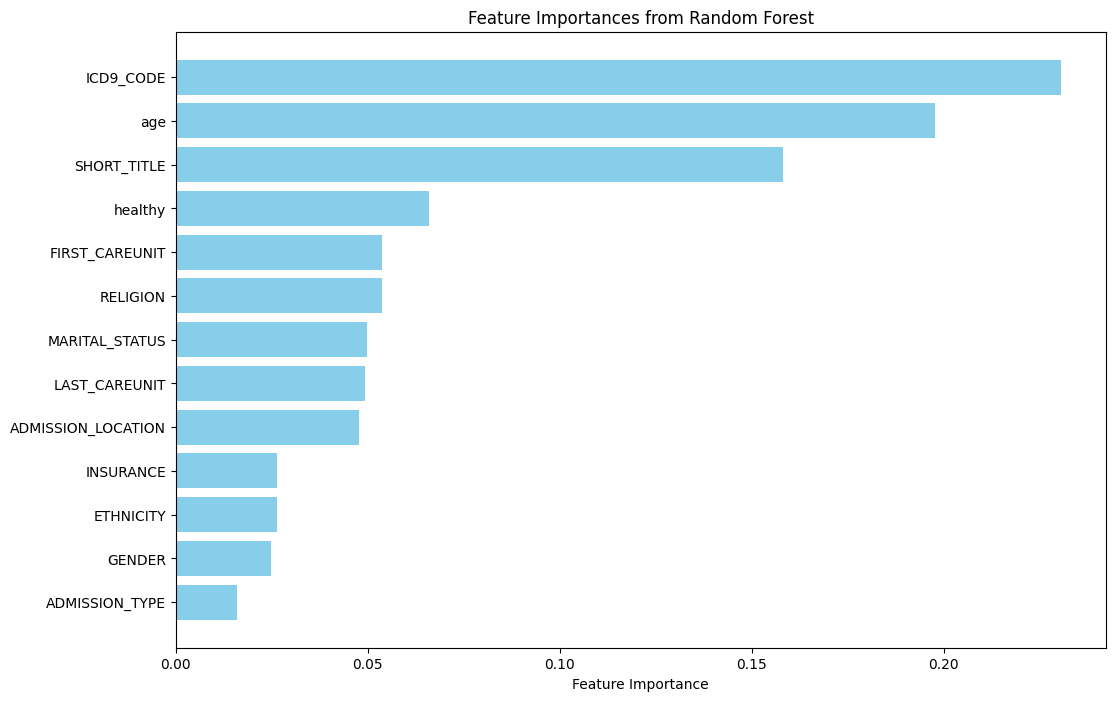

In [ ]:
from dask_ml.wrappers import ParallelPostFit
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Define the model pipeline with limited tree depth
max_depth = 10  # You can adjust this value as needed

pipeline = Pipeline([
    ('regressor', ParallelPostFit(RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=42)))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the testing set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

# Compute score (assuming LOS is the target variable)
mape = np.mean(np.abs((y_test- y_pred) / np.abs(y_test)))
score = 100 * (1 - mape)
print('Mape score:', score)

# Access the underlying RandomForestRegressor
rf_regressor = pipeline.named_steps['regressor'].estimator

# Print the depth of each tree
tree_depths = [tree.tree_.max_depth for tree in rf_regressor.estimators_]
print('Tree depths:', tree_depths)
print('Average tree depth:', np.mean(tree_depths))
print('Max tree depth:', np.max(tree_depths))

# Print feature importances
feature_importances = rf_regressor.feature_importances_
features = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print('Feature Importances:')
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Conclusion and final remarks

##This project has significantly enhanced our understanding of the MIMIC-III dataset and the complexities of big data analysis in healthcare.

##This model can be extremely useful for hospitals, enabling them to predict the duration of ICU stays and optimize resource allocation, improve patient flow, and enhance overall hospital management. Additionally, the practical applications of our model include better capacity planning and timely patient care.
##Future work: refining the model with additional features, implementing real-time predictions, and validating the model across different hospital settings to ensure robustness and generalizability. This project underscores the importance of leveraging big data and predictive analytics to drive improvements in healthcare.





# References

Information about choices of using some columns:

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10731672/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10165982/


Groups of the ICD9_CODES:

https://en.wikipedia.org/wiki/List_of_ICD-9_codes